In [1]:
import pickle

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.multirun import get_coeffs_reps_tangent
from codes.otherfunctions.multirun import get_grads_reps_pca2_tangent
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_tangent
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.get_grads_tangent import get_grads_tangent
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
import matplotlib.pyplot as plt
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.geometer.RiemannianManifold import RiemannianManifold
from collections import Counter

/Users/samsonkoelle/manifoldflasso_jmlr


In [214]:

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

    #handles, labels = ax.get_legend_handles_labels()
    #by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    #fig.subplots_adjust(right=0.75)
    #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    #leg_ax.axis('off')
    #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    #for l in leg.get_lines():
    #    l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))

In [173]:
nreps= 25
dim = 2
#from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/rigidethanol/rigidethanol_110120replicates_fix.pkl' ,
         'rb') as loader:
     replicates_rigidethanol = pickle.load(loader)

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_110120replicates.pkl' ,
         'rb') as loader:
     replicates_ethanol = pickle.load(loader)
        
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/toluene/toluene_110120replicates.pkl' ,
         'rb') as loader:
     replicates_toluene = pickle.load(loader)
        
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_110120replicates.pkl' ,
         'rb') as loader:
     replicates_malonaldehyde = pickle.load(loader)
         

In [174]:
nreps= 25
dim = 2
#from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
def get_support(coeffs, dim):
    selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

    if len(np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]) > 0:
        selection_lambda = np.min(np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0])

        selected_functions_at_selection_lambda = selected_functions[1][np.where(selected_functions[0] == selection_lambda)[0]]
    
        return(selected_functions_at_selection_lambda)
    else:
        return(np.asarray([]))

def get_toplot(supports,p,d):
    to_plot = np.zeros(np.repeat(p,d))
    support_indices = np.asarray(list(supports.values()))
    
    for i in range(len(support_indices)):
        if type(support_indices[i]) == np.ndarray:
            if len(support_indices[i]) > 0:
                #print(tuple(support_indices[i]), to_plot[tuple(support_indices[i])])#, print(to_plot[-1])
                to_plot[tuple(support_indices[i])] += 1

    return(to_plot)

supports_rigidethanol = {}
for i in range(nreps):
    print(i)
    supports_rigidethanol[i] = get_support(replicates_rigidethanol[i].coeffs, dim = 2)

supports_ethanol = {}
for i in range(nreps):
    print(i)
    supports_ethanol[i] = get_support(replicates_ethanol[i].coeffs, dim = 2)
    
supports_toluene = {}
for i in range(nreps):
    print(i)
    supports_toluene[i] = get_support(replicates_toluene[i].coeffs, dim = 1)

supports_malonaldehyde = {}
for i in range(nreps):
    print(i)
    supports_malonaldehyde[i] = get_support(replicates_malonaldehyde[i].coeffs, dim = 2)
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [175]:
# supports = supports_toluene 
# p = 30

In [176]:
#     d = 1
#     to_plot = np.zeros(np.repeat(p,d))
#     support_indices = np.asarray(list(supports.values()))
    
#     for i in range(len(support_indices)):
#         print(i)
#         if type(support_indices[i]) == np.ndarray:
#             if len(support_indices[i]) > 0:
#                 to_plot[tuple(support_indices[i])] += 1
#                 #to_plot[support_indices[i][1], support_indices[i][0]] += 1

In [177]:

toplot_toluene = get_toplot(supports_toluene, 30,1)

toplot_rigidethanol = get_toplot(supports_rigidethanol, 12,2)

toplot_ethanol = get_toplot(supports_ethanol, 12,2)

toplot_malonaldehyde = get_toplot(supports_malonaldehyde, 12,2)

In [178]:
#rt = replicates_toluene[i]

In [179]:
# coeffs = replicates_ethanol[i].coeffs
# dim = 2

In [180]:
#     selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

#     if len(np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]) > 0:
#         selection_lambda = np.min(np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0])

#         selected_functions_at_selection_lambda = selected_functions[1][np.where(selected_functions[0] == selection_lambda)[0]]


In [14]:
# def get_support(coeffs, dim):
#     selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

#     selection_lambda = np.min(np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0])

#     selected_functions_at_selection_lambda = selected_functions[1][
#         np.where(selected_functions[0] == selection_lambda)[0]]

#     return (selected_functions_at_selection_lambda)

In [91]:
replicates_toluene[0].dg_M.shape

(100, 30, 1)

In [181]:
def plot_watch(to_plot, p):
    #fig, ax = plt.subplots(figsize = (15,15))
    %matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    axes.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        axes.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=cmap.colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



        axes.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                plt.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    axes.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    axes.set_aspect(1)
    axes.set_axis_off()

1.0 0.0
0.9781476007338057 0.20791169081775931
0.9135454576426009 0.40673664307580015
0.8090169943749475 0.5877852522924731
0.6691306063588583 0.7431448254773941
0.5000000000000001 0.8660254037844386
0.30901699437494745 0.9510565162951535
0.10452846326765367 0.9945218953682733
-0.10452846326765333 0.9945218953682734
-0.30901699437494734 0.9510565162951536
-0.4999999999999998 0.8660254037844388
-0.6691306063588579 0.7431448254773945
-0.8090169943749473 0.5877852522924732
-0.9135454576426008 0.40673664307580043
-0.9781476007338056 0.20791169081775973
-1.0 1.2246467991473532e-16
-0.9781476007338057 -0.20791169081775907
-0.9135454576426011 -0.4067366430757998
-0.8090169943749475 -0.587785252292473
-0.6691306063588585 -0.743144825477394
-0.5000000000000004 -0.8660254037844384
-0.30901699437494756 -0.9510565162951535
-0.10452846326765423 -0.9945218953682733
0.104528463267653 -0.9945218953682734
0.30901699437494723 -0.9510565162951536
0.4999999999999993 -0.866025403784439
0.6691306063588578 -

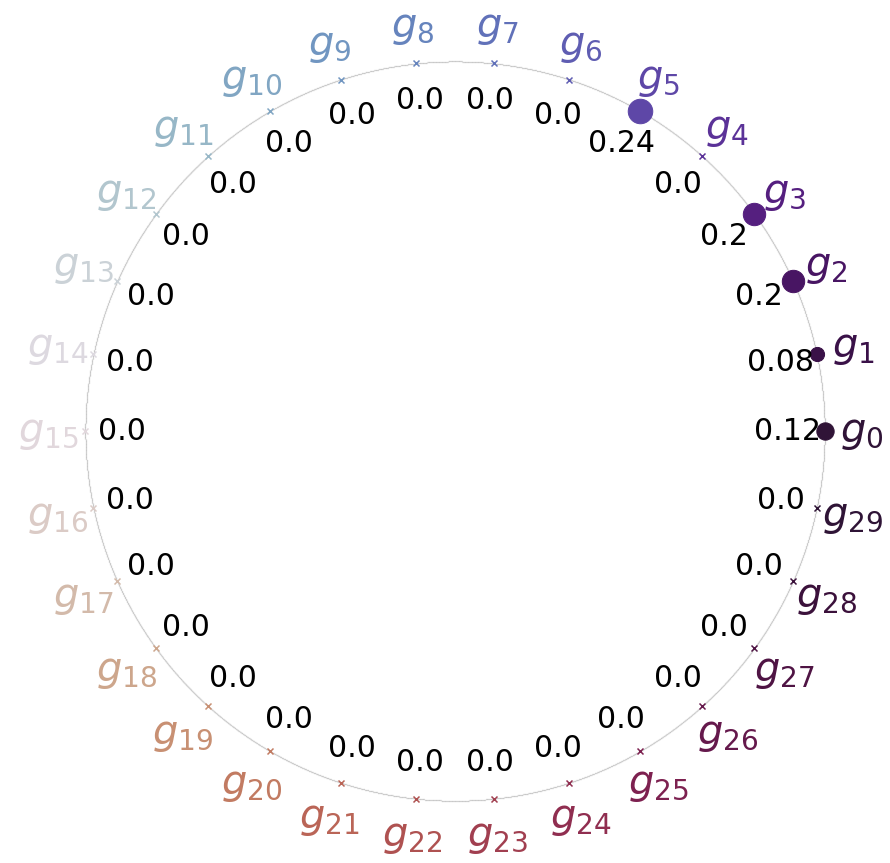

In [16]:
plot_watch(toplot_toluene, 30)

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


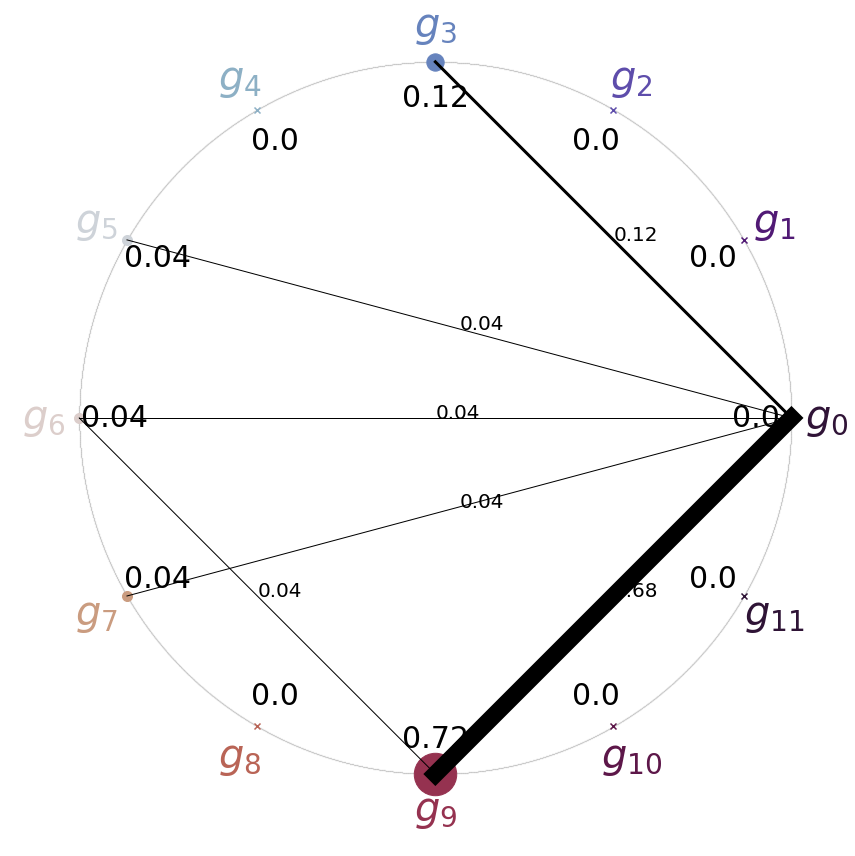

In [17]:
plot_watch(toplot_ethanol, 12)

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


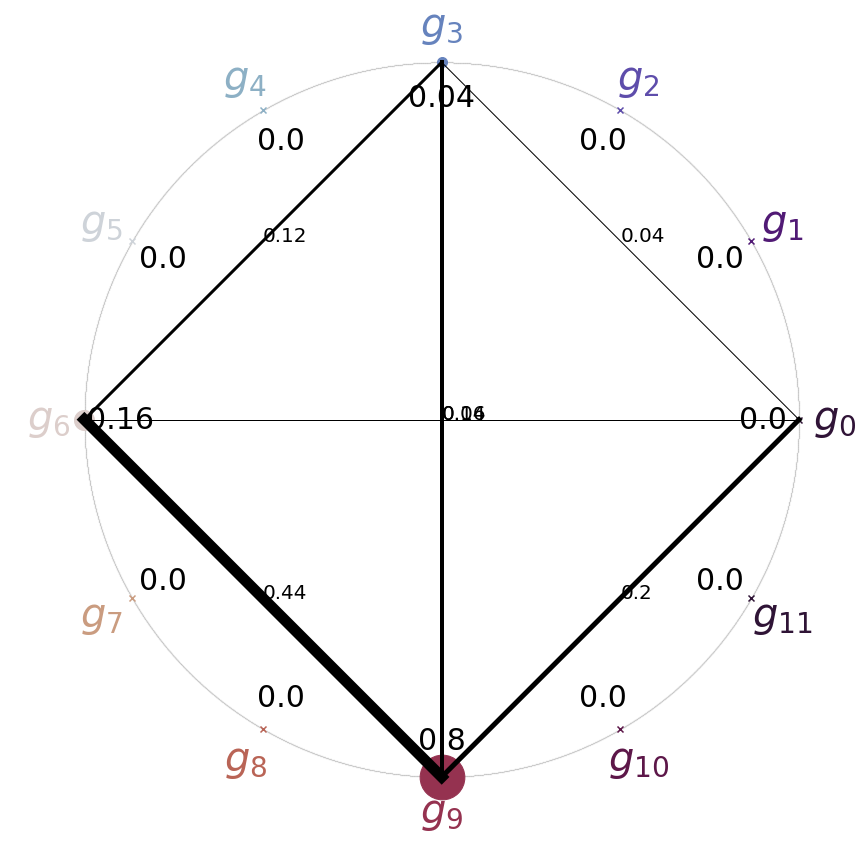

In [18]:
plot_watch(toplot_rigidethanol, 12)

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


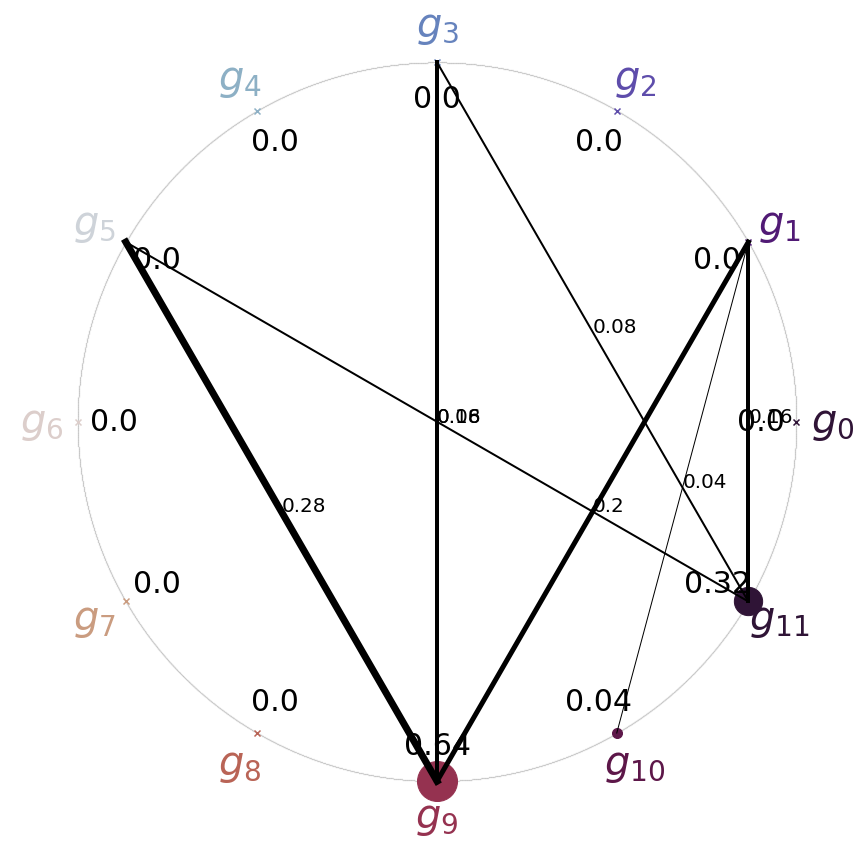

In [19]:
plot_watch(toplot_malonaldehyde, 12)

In [182]:


def get_penalty(coeffs):
    pen = np.sum(np.linalg.norm(coeffs, axis=1))
    return (pen)


def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)


# def get_cosines(self, dg):
def get_cosines(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,
                                                                :])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    cos_summary = np.sum(coses ** 2, axis=0) / n
    return (cos_summary)


In [183]:
import matplotlib.pyplot as plt

In [184]:
from pylab import rcParams
def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)


In [195]:
def plot_watch_custom(to_plot, p, ax,colors):
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=colors[j],#cmap.colors[j],
                  fontdict = {'fontsize' : 70},
                  horizontalalignment='center',
         verticalalignment='center')



        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 200*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 40})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()
    ax.set_title(r"$\omega = 25$")

In [229]:
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral.pkl' ,
        'rb') as output:
    replicates_swiss_spectral = pickle.load(output)
    
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap.pkl' ,
        'rb') as output:
    replicates_swiss_isomap = pickle.load(output)

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal.pkl' ,
        'rb') as output:
    replicates_swiss_internal = pickle.load(output)
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.pkl' ,
        'rb') as output:
    replicates_swiss_ltsa = pickle.load(output)


In [154]:

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        
    axes[0].set_ylabel(r"$\|\beta\|$", fontsize = 50)
        
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    fig.subplots_adjust(right=0.75)
    leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    leg_ax.axis('off')
    leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    for l in leg.get_lines():
        l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))



In [45]:
from matplotlib import rcParams

def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)
import math
from collections import OrderedDict

<IPython.core.display.Javascript object>


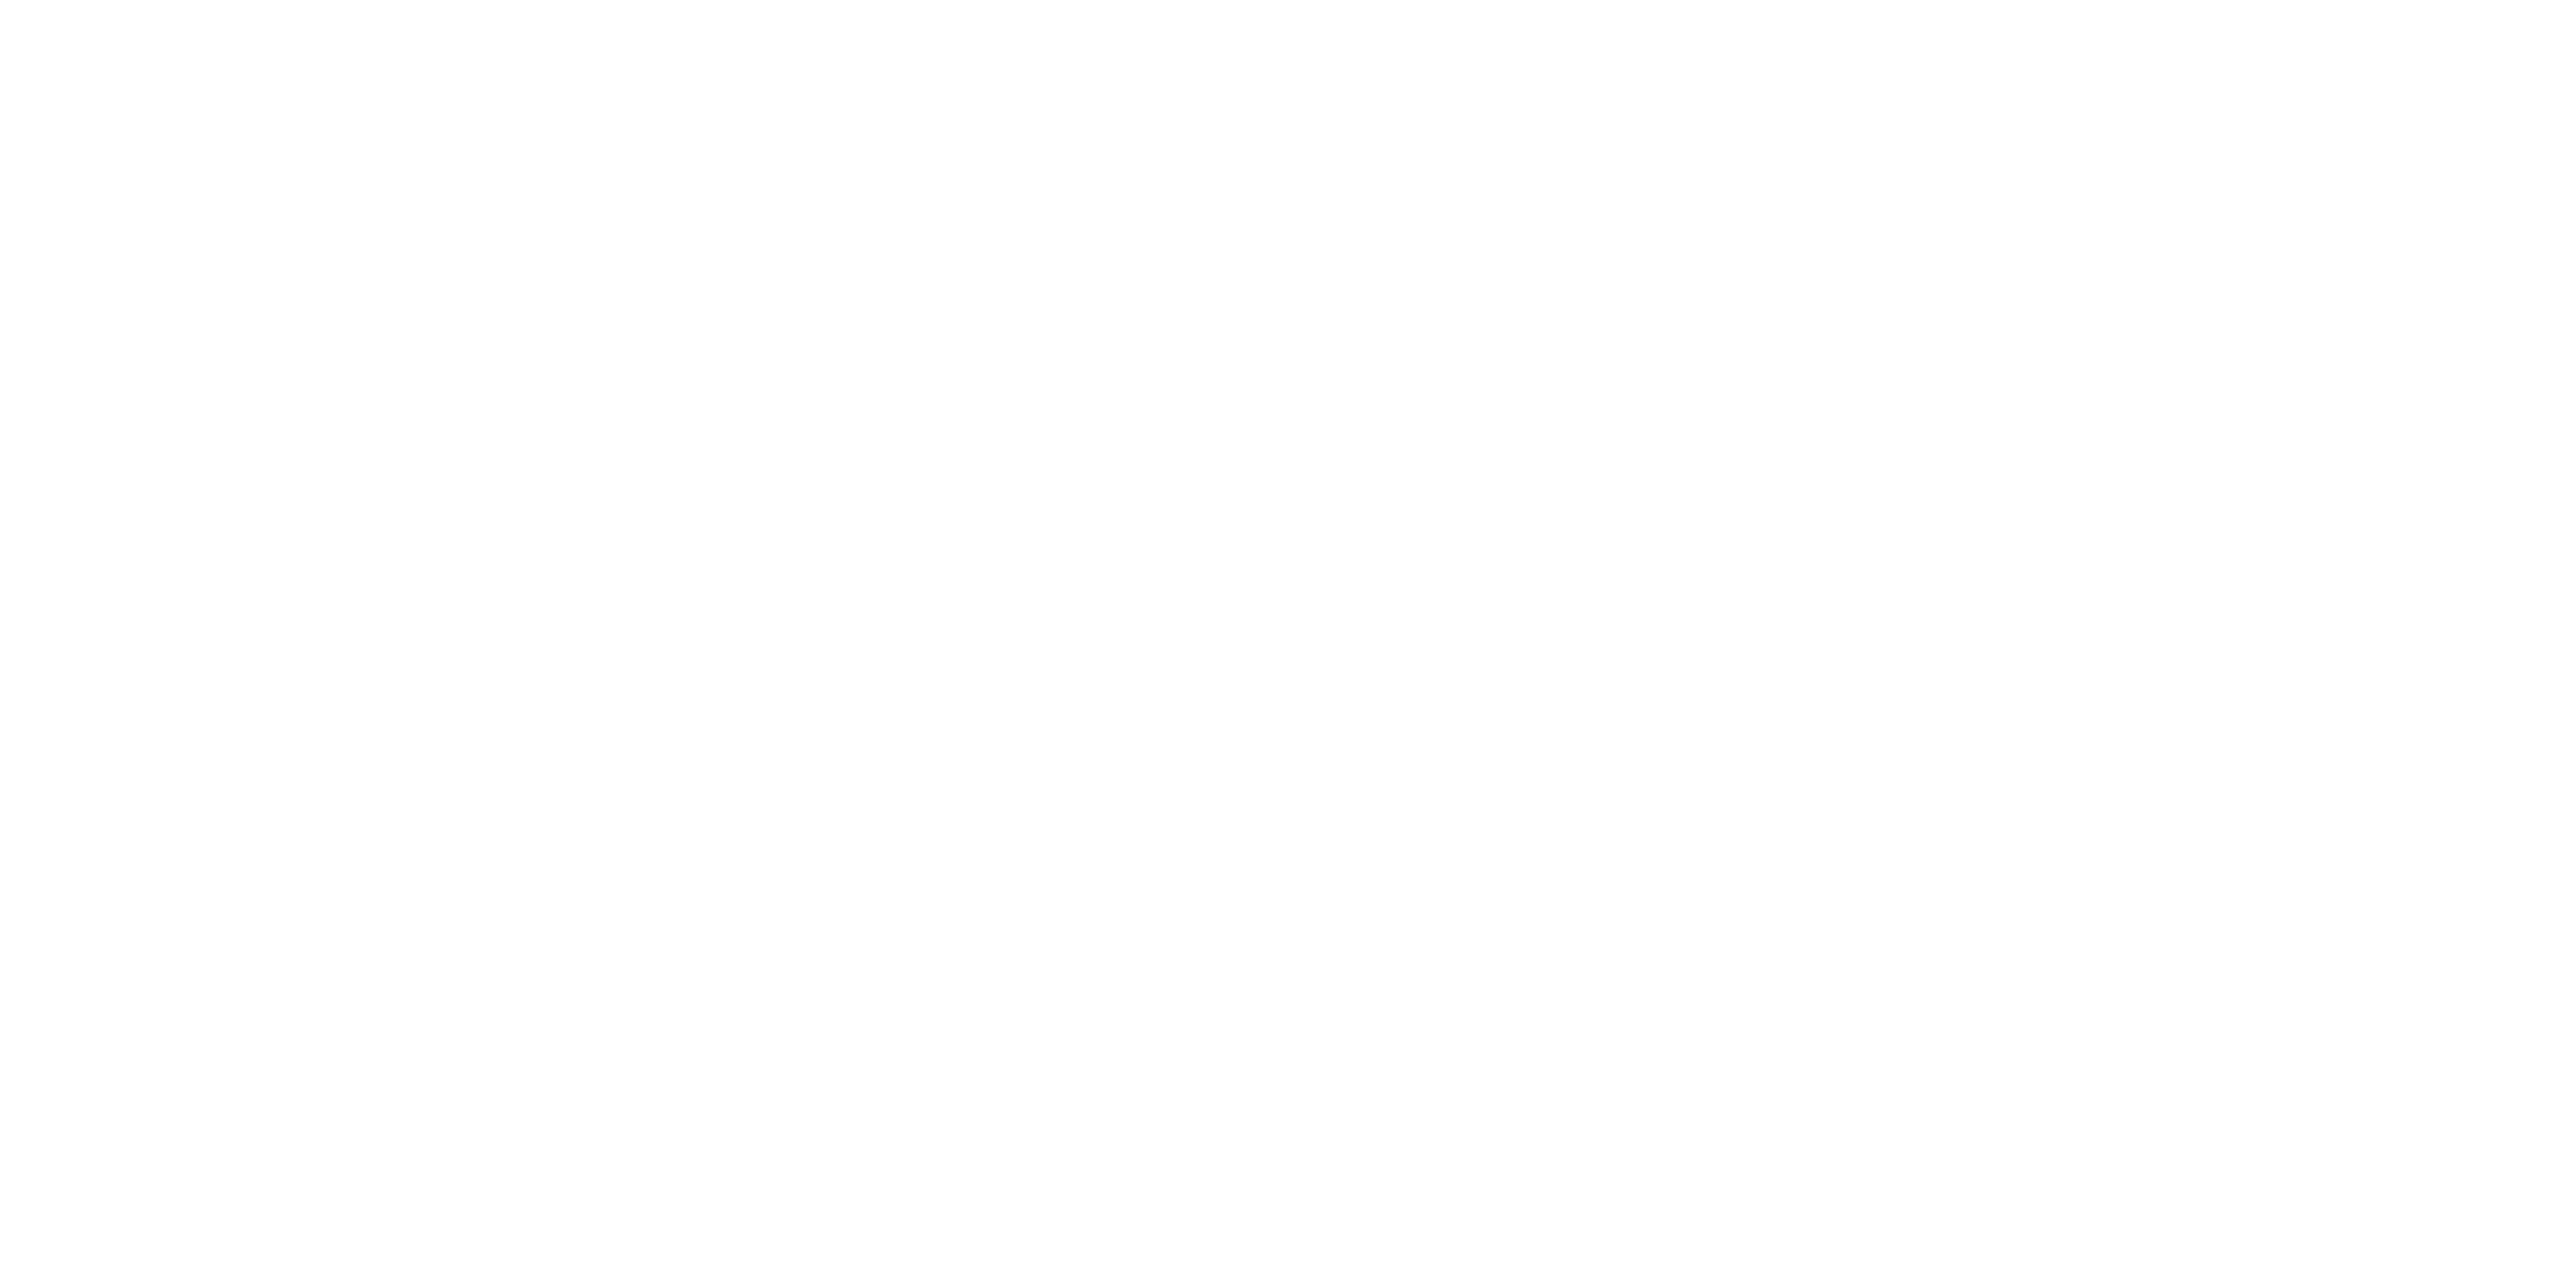

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


NameError: name 'folder' is not defined

<IPython.core.display.Javascript object>


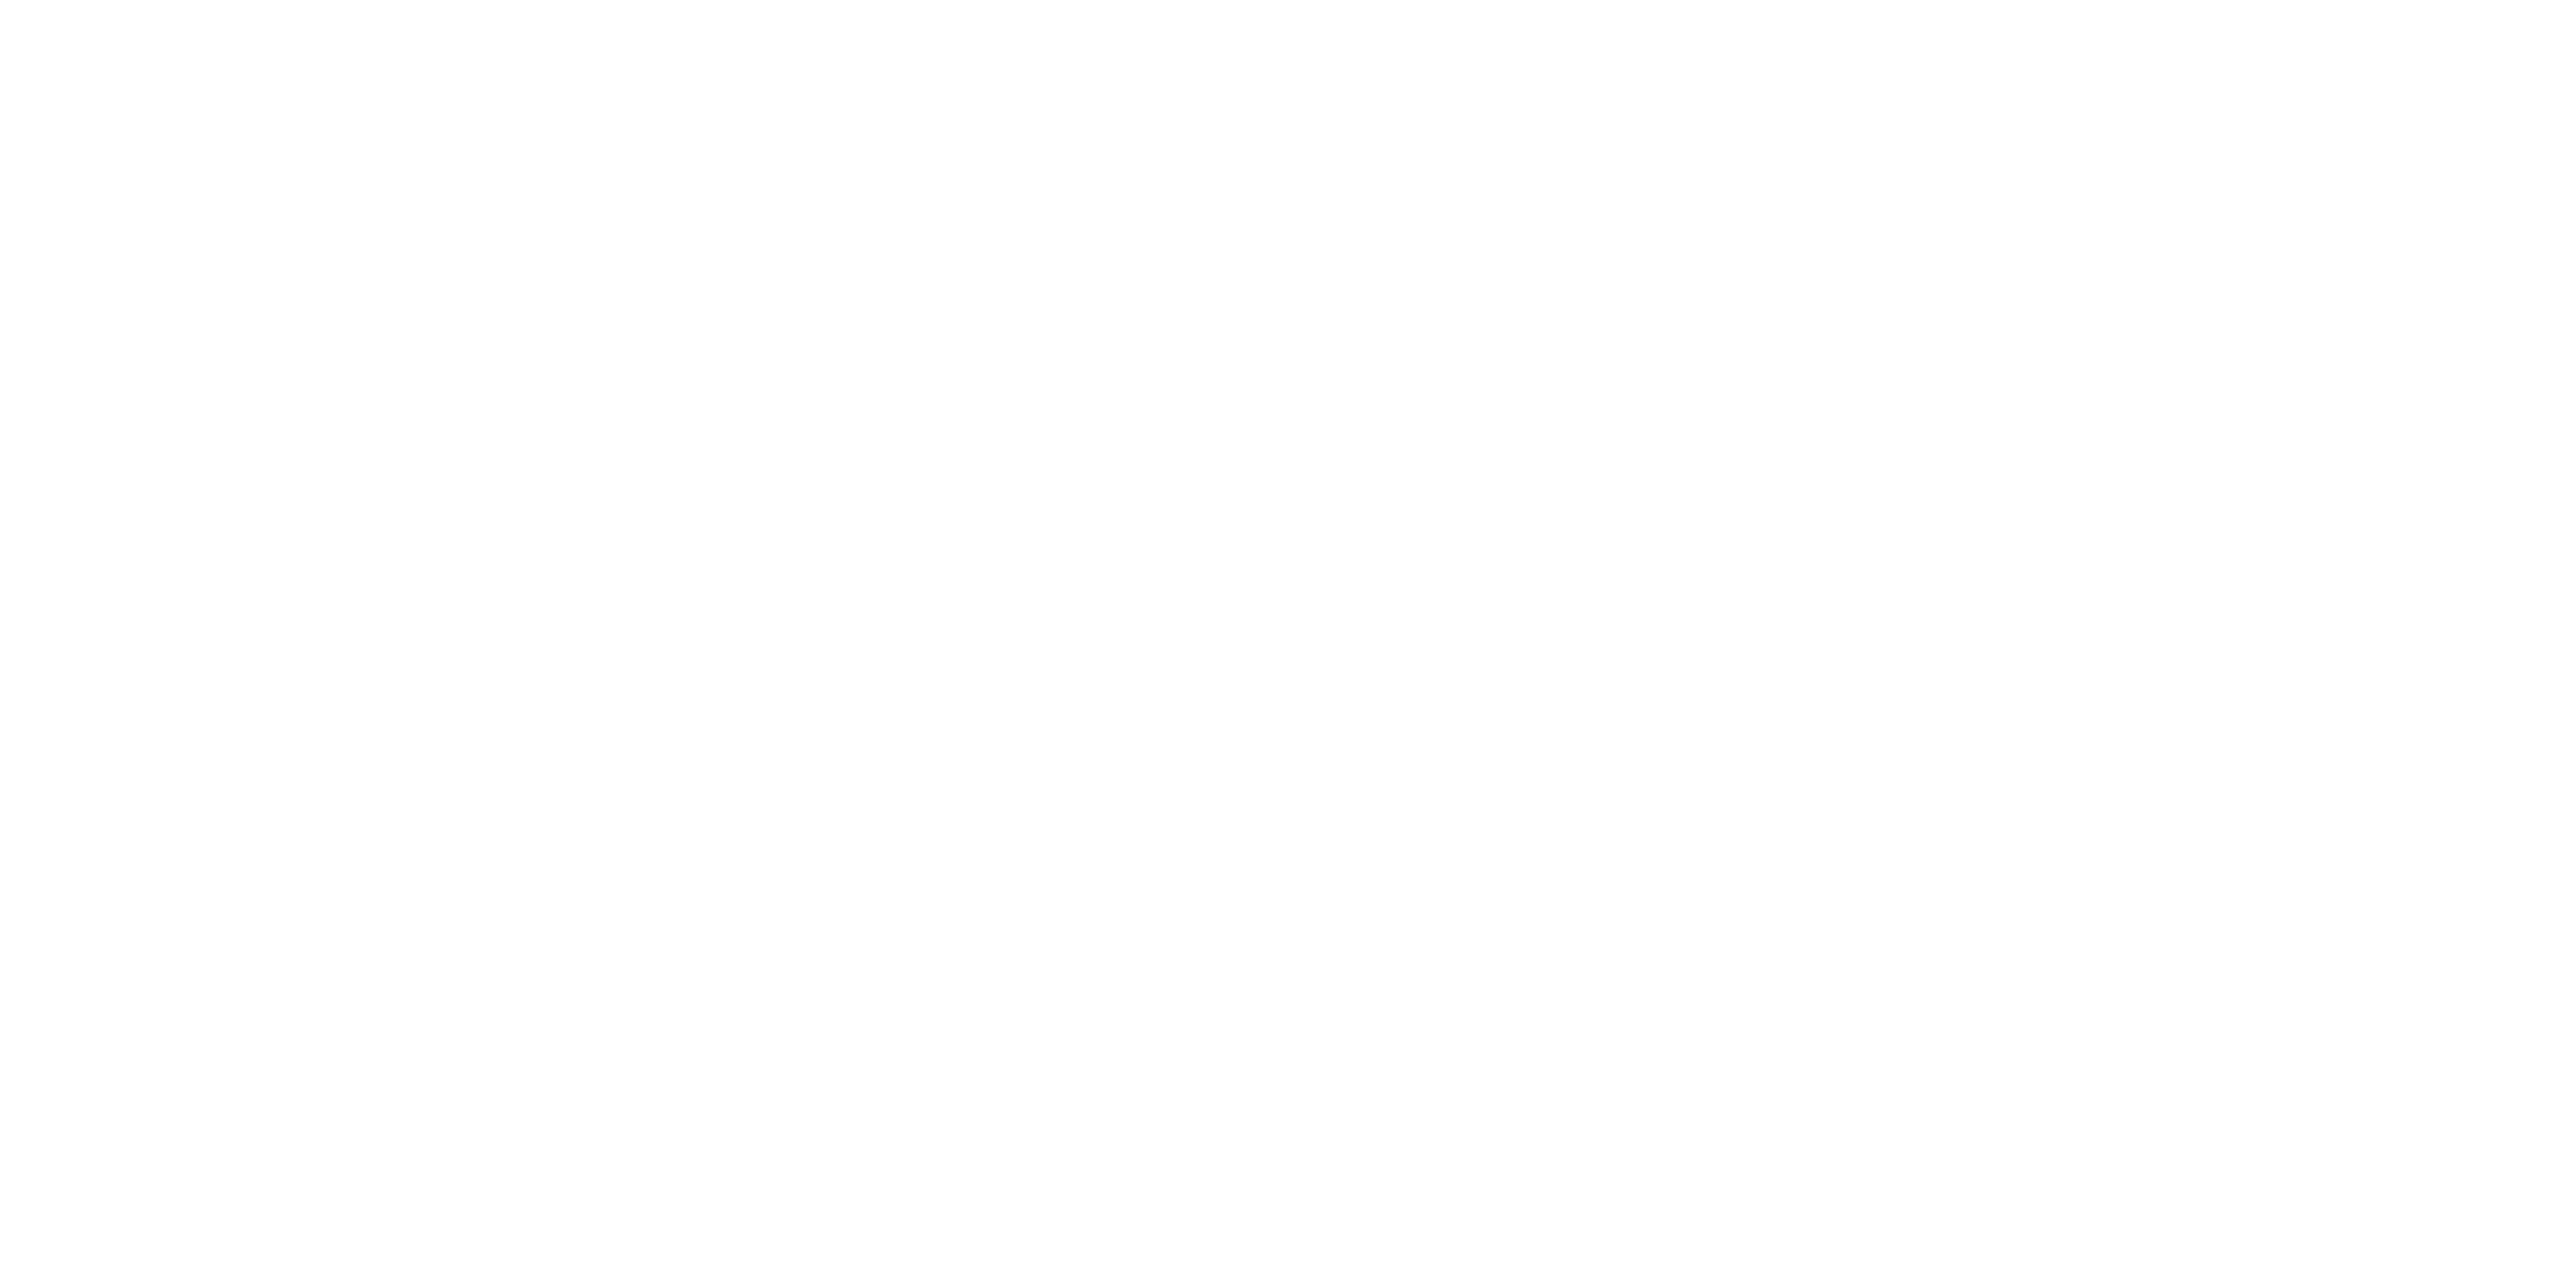

In [113]:
%matplotlib notebook
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
i = 0
m=  2
nreps = 2
nsel = 5
fig, axes_all = plt.subplots(4, 4,figsize=(15 * 4, 15*nreps))
fig.suptitle('Regularization paths')
plot_reg_path_ax_lambdasearch_customcolors(axes_all[0], replicates_swiss_internal[i].coeffs, replicates_swiss_internal[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[1], replicates_swiss_spectral[i].coeffs, replicates_swiss_spectral[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[2], replicates_swiss_isomap[i].coeffs, replicates_swiss_isomap[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[3], replicates_swiss_ltsa[i].coeffs, replicates_swiss_ltsa[i].lambdas_plot * np.sqrt(m * nsel), fig,colors)
fig.savefig(folder + '/swiss_combined2')


In [221]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])


In [222]:
swiss_ltsa =np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.npy')
swiss_internal = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal.npy')
swiss_isomap = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap.npy')
swiss_spectral = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral.npy')

In [223]:
%matplotlib inline

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


AttributeError: 'Replicate' object has no attribute 'coeffs'

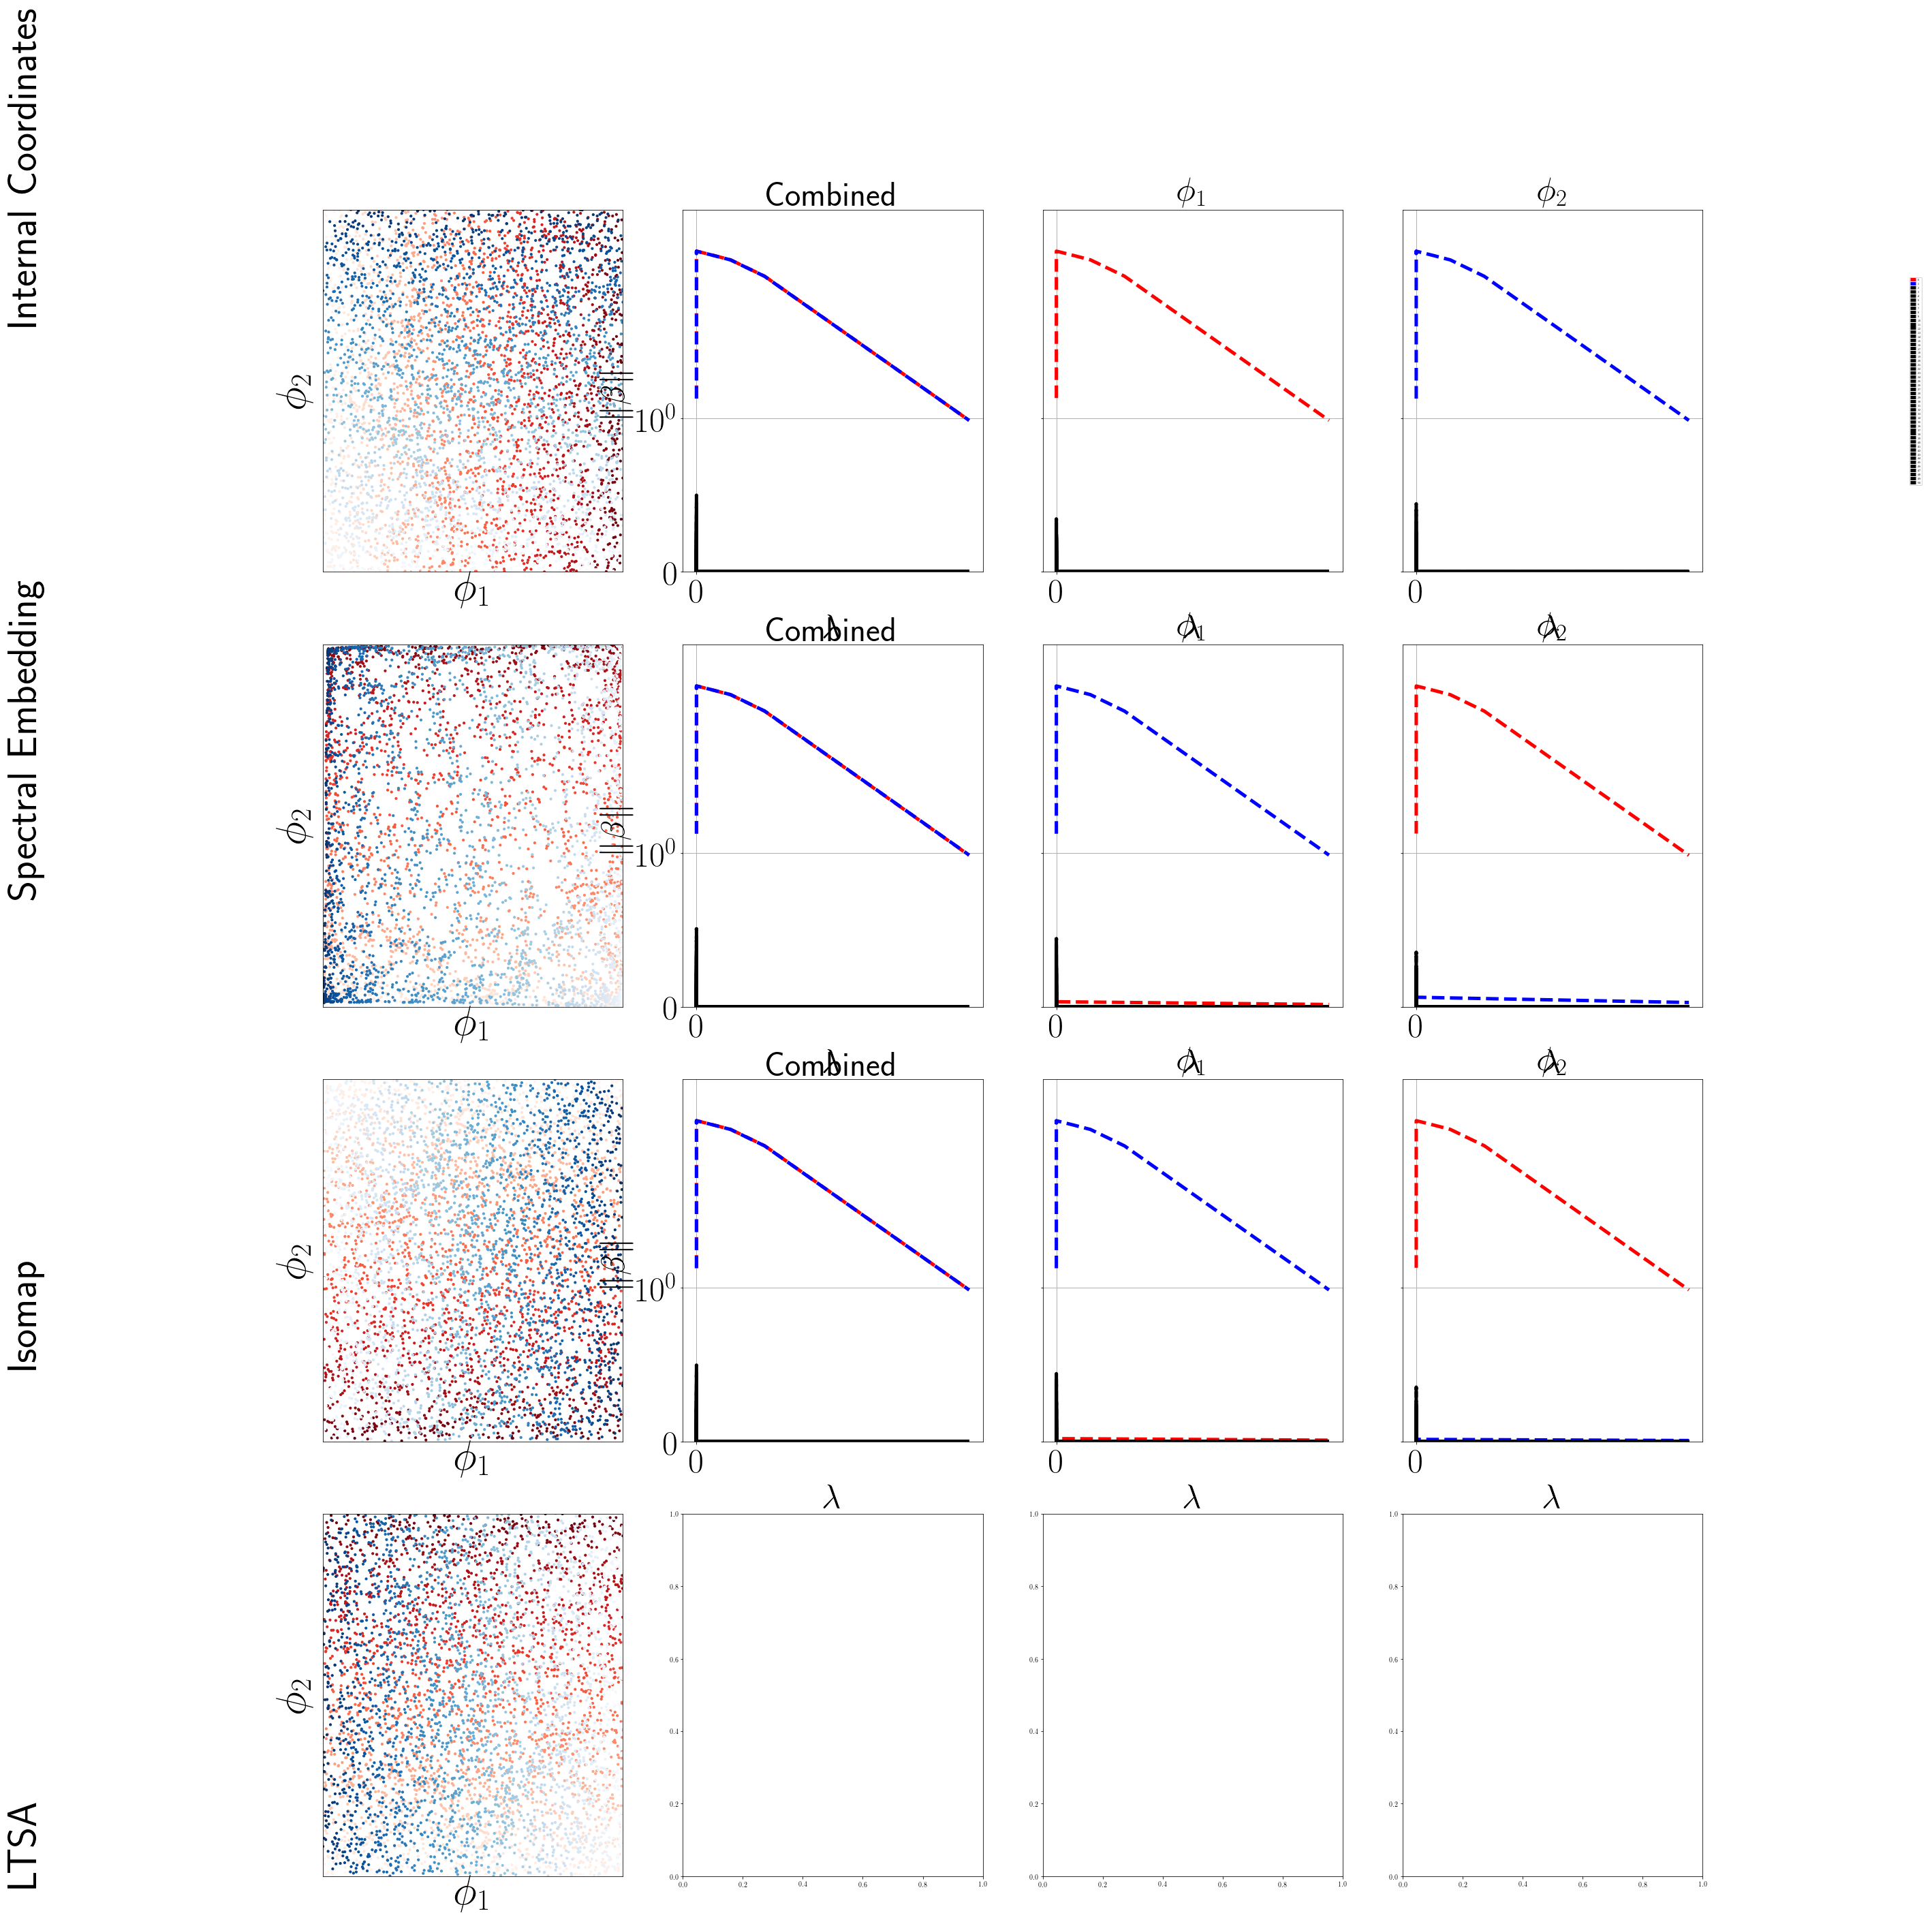

In [228]:
fig, axes_all = plt.subplots(4, 4,figsize=(45,45) )#15*nreps))
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1
axes_all[0,0].scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[0,0].scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[0,0].set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all[0,0].set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all[0,0].set_xticks([])
axes_all[0,0].set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all[0,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[0,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.9, 'Internal Coordinates', ha='center', va='center', rotation='vertical', fontsize = 60)


axes_all[1,0].scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[1,0].scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[1,0].set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all[1,0].set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all[1,0].set_xticks([])
axes_all[1,0].set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all[1,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.01, 0.64, 'Spectral Embedding', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[2,0].scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[2,0].scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[2,0].set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all[2,0].set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all[2,0].set_xticks([])
axes_all[2,0].set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all[2,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[2,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.38, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[3,0].scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[3,0].scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[3,0].set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all[3,0].set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all[3,0].set_xticks([])
axes_all[3,0].set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all[3,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[3,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.14, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

#axes_all[1,0].plot(swiss_spectral)
#axes_all[2,0].plot(swiss_isomap)
#axes_all[3,0].plot(swiss_ltsa)

plot_reg_path_ax_lambdasearch_customcolors(axes_all[0][1:], replicates_swiss_internal[0].coeffs, replicates_swiss_internal[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[1][1:], replicates_swiss_spectral[0].coeffs, replicates_swiss_spectral[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[2][1:], replicates_swiss_isomap[0].coeffs, replicates_swiss_isomap[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[3][1:], replicates_swiss_ltsa[0].coeffs, replicates_swiss_ltsa[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)

fig.tight_layout()

plt.savefig('swissgood2', bbox_inches = "tight")

In [186]:
rs = replicates_swiss_internal[i]

KeyError: 24

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


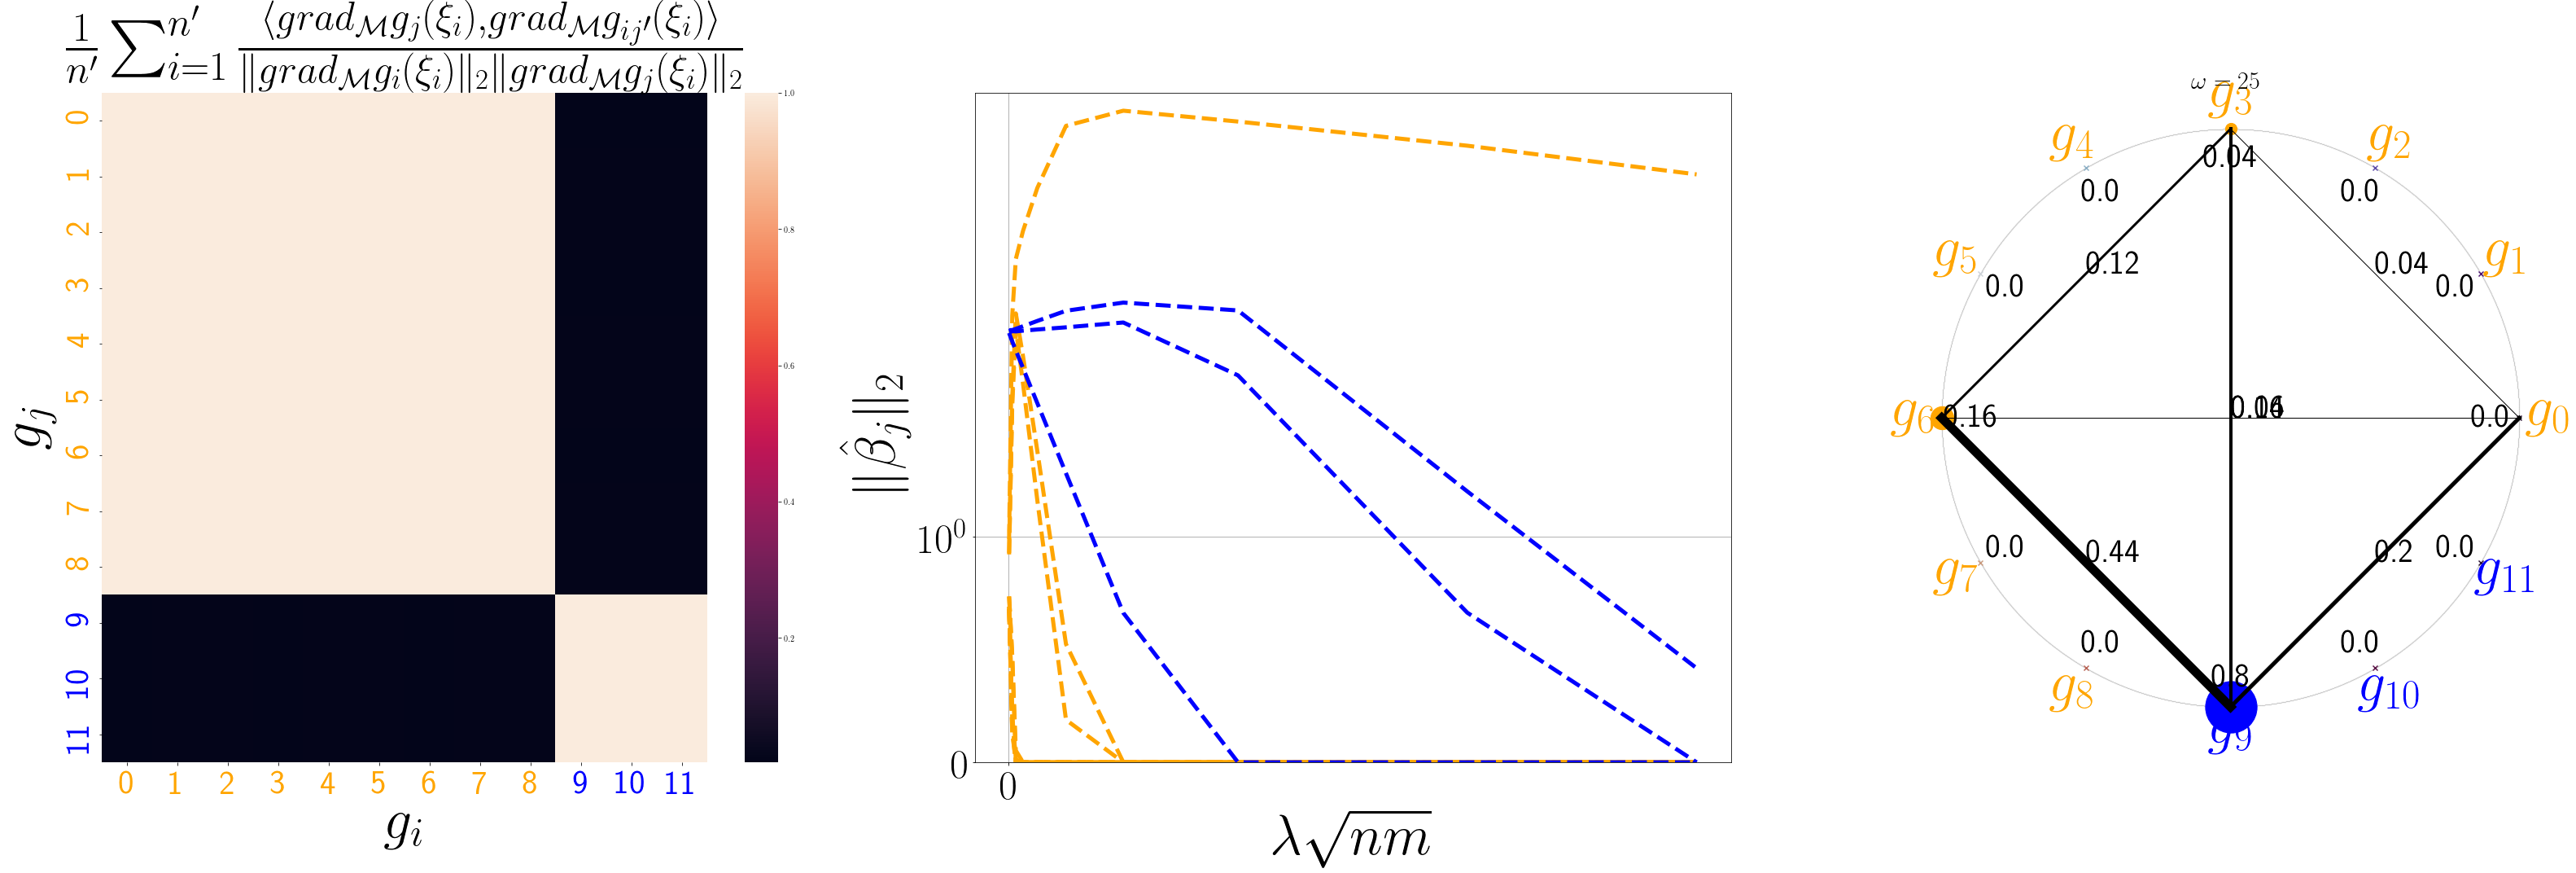

In [215]:
%matplotlib inline
#fig,axes == plt.subplot(3,3,figsize=(15,15))
fig, axes_all = plt.subplots(1,3,figsize=(45,15))

reth_cosine = get_cosines(replicates_rigidethanol[1].dg_M)
#sns.heatmap(eth_cosine, ax = axes_all[0,0],)
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(reth_cosine, axes_all[0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[1], replicates_rigidethanol[1].coeffs, replicates_rigidethanol[1].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_rigidethanol, 12, axes_all[2],colors)

fig.tight_layout()
plt.savefig('bigwan_re')

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


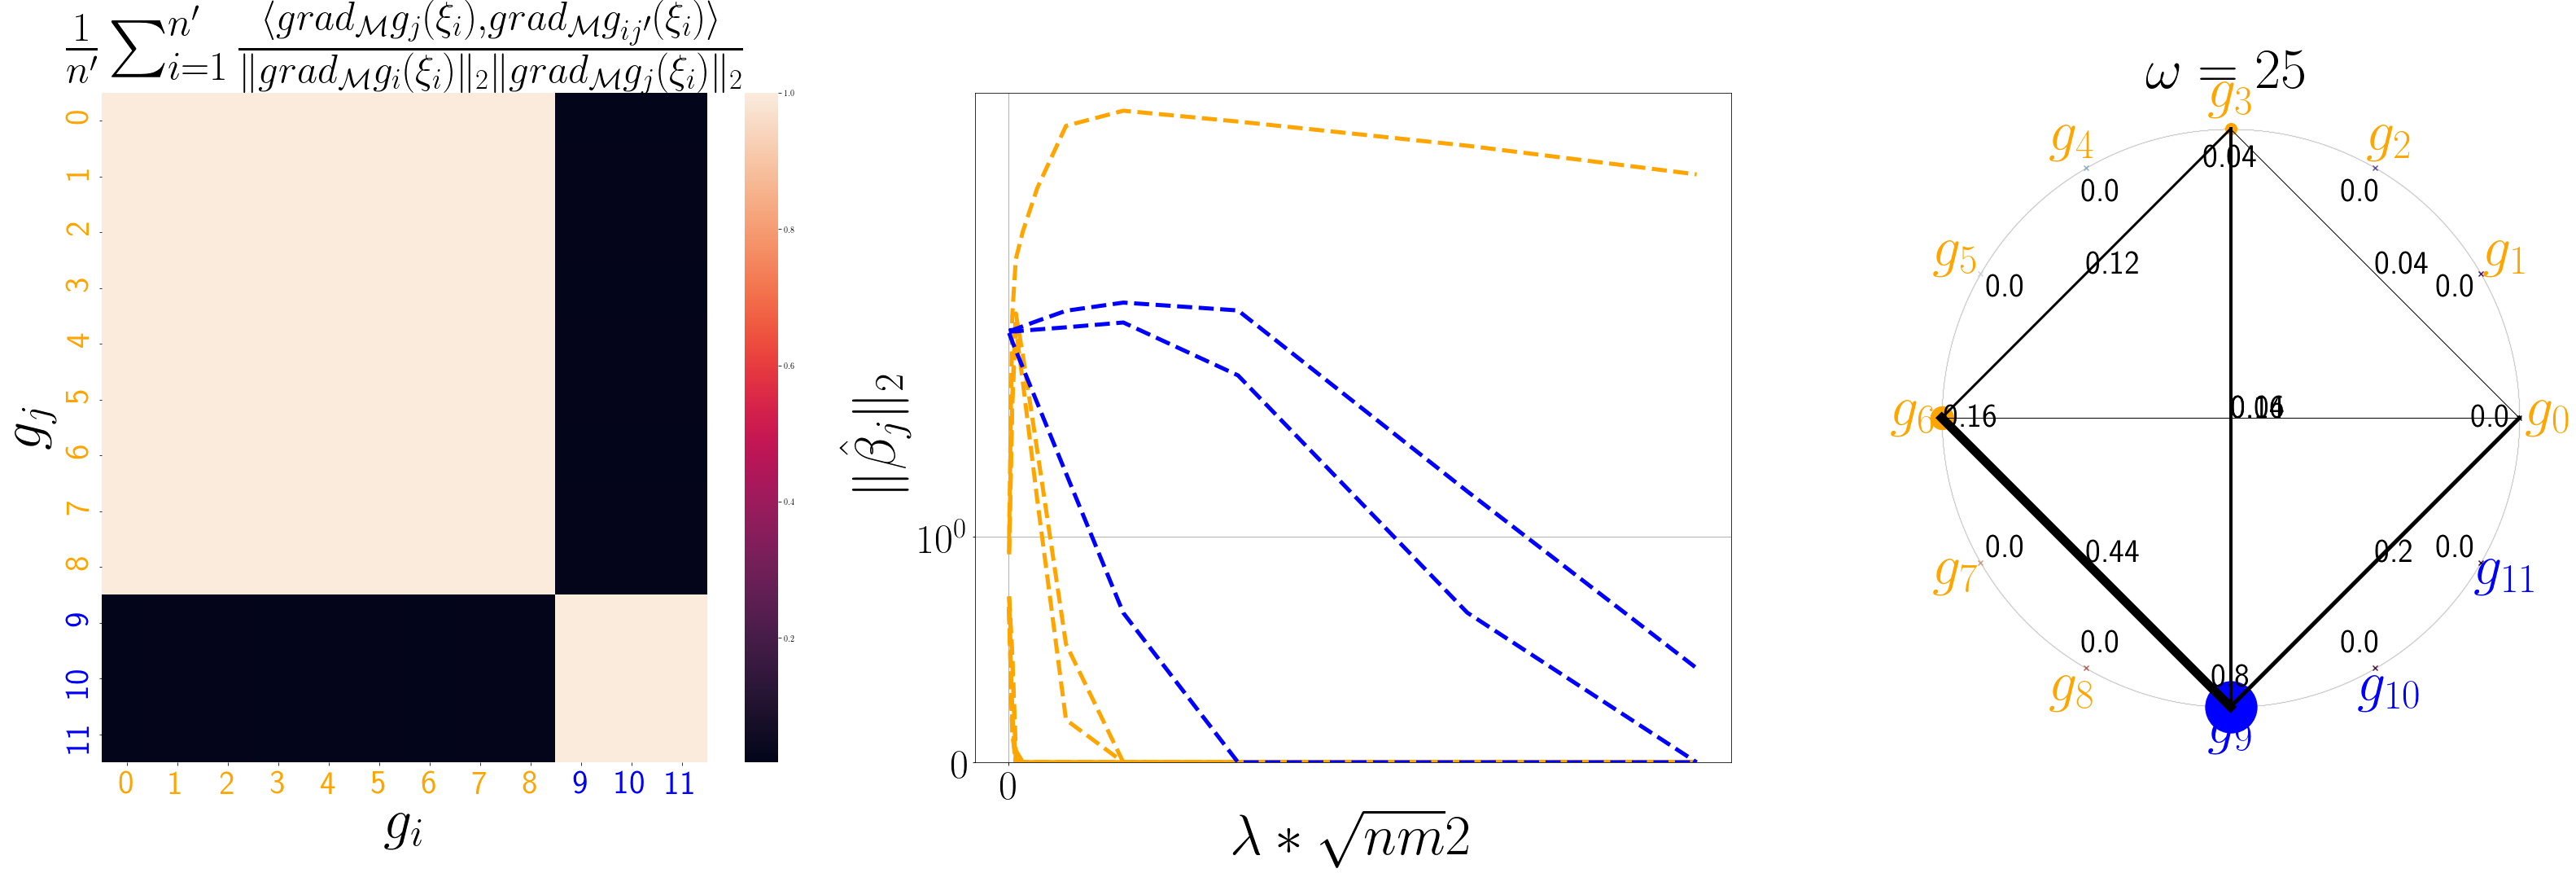

In [174]:
%matplotlib inline
#fig,axes == plt.subplot(3,3,figsize=(15,15))
fig, axes_all = plt.subplots(1,3,figsize=(45,15))

reth_cosine = get_cosines(replicates_rigidethanol[1].dg_M)
#sns.heatmap(eth_cosine, ax = axes_all[0,0],)
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(reth_cosine, axes_all[0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[1], replicates_rigidethanol[1].coeffs, replicates_rigidethanol[1].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_rigidethanol, 12, axes_all[2],colors)

fig.tight_layout()
plt.savefig('bigwan_re')

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004
1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004
1.0 0.0
0.9781476007338057 0.20791169081775931
0.9135454576426009 0.40673664307580015
0.8090169943749475 0.5877852522924731
0.6691306063588583 0.7431448254773941
0.5000000000000001 0.86602540378

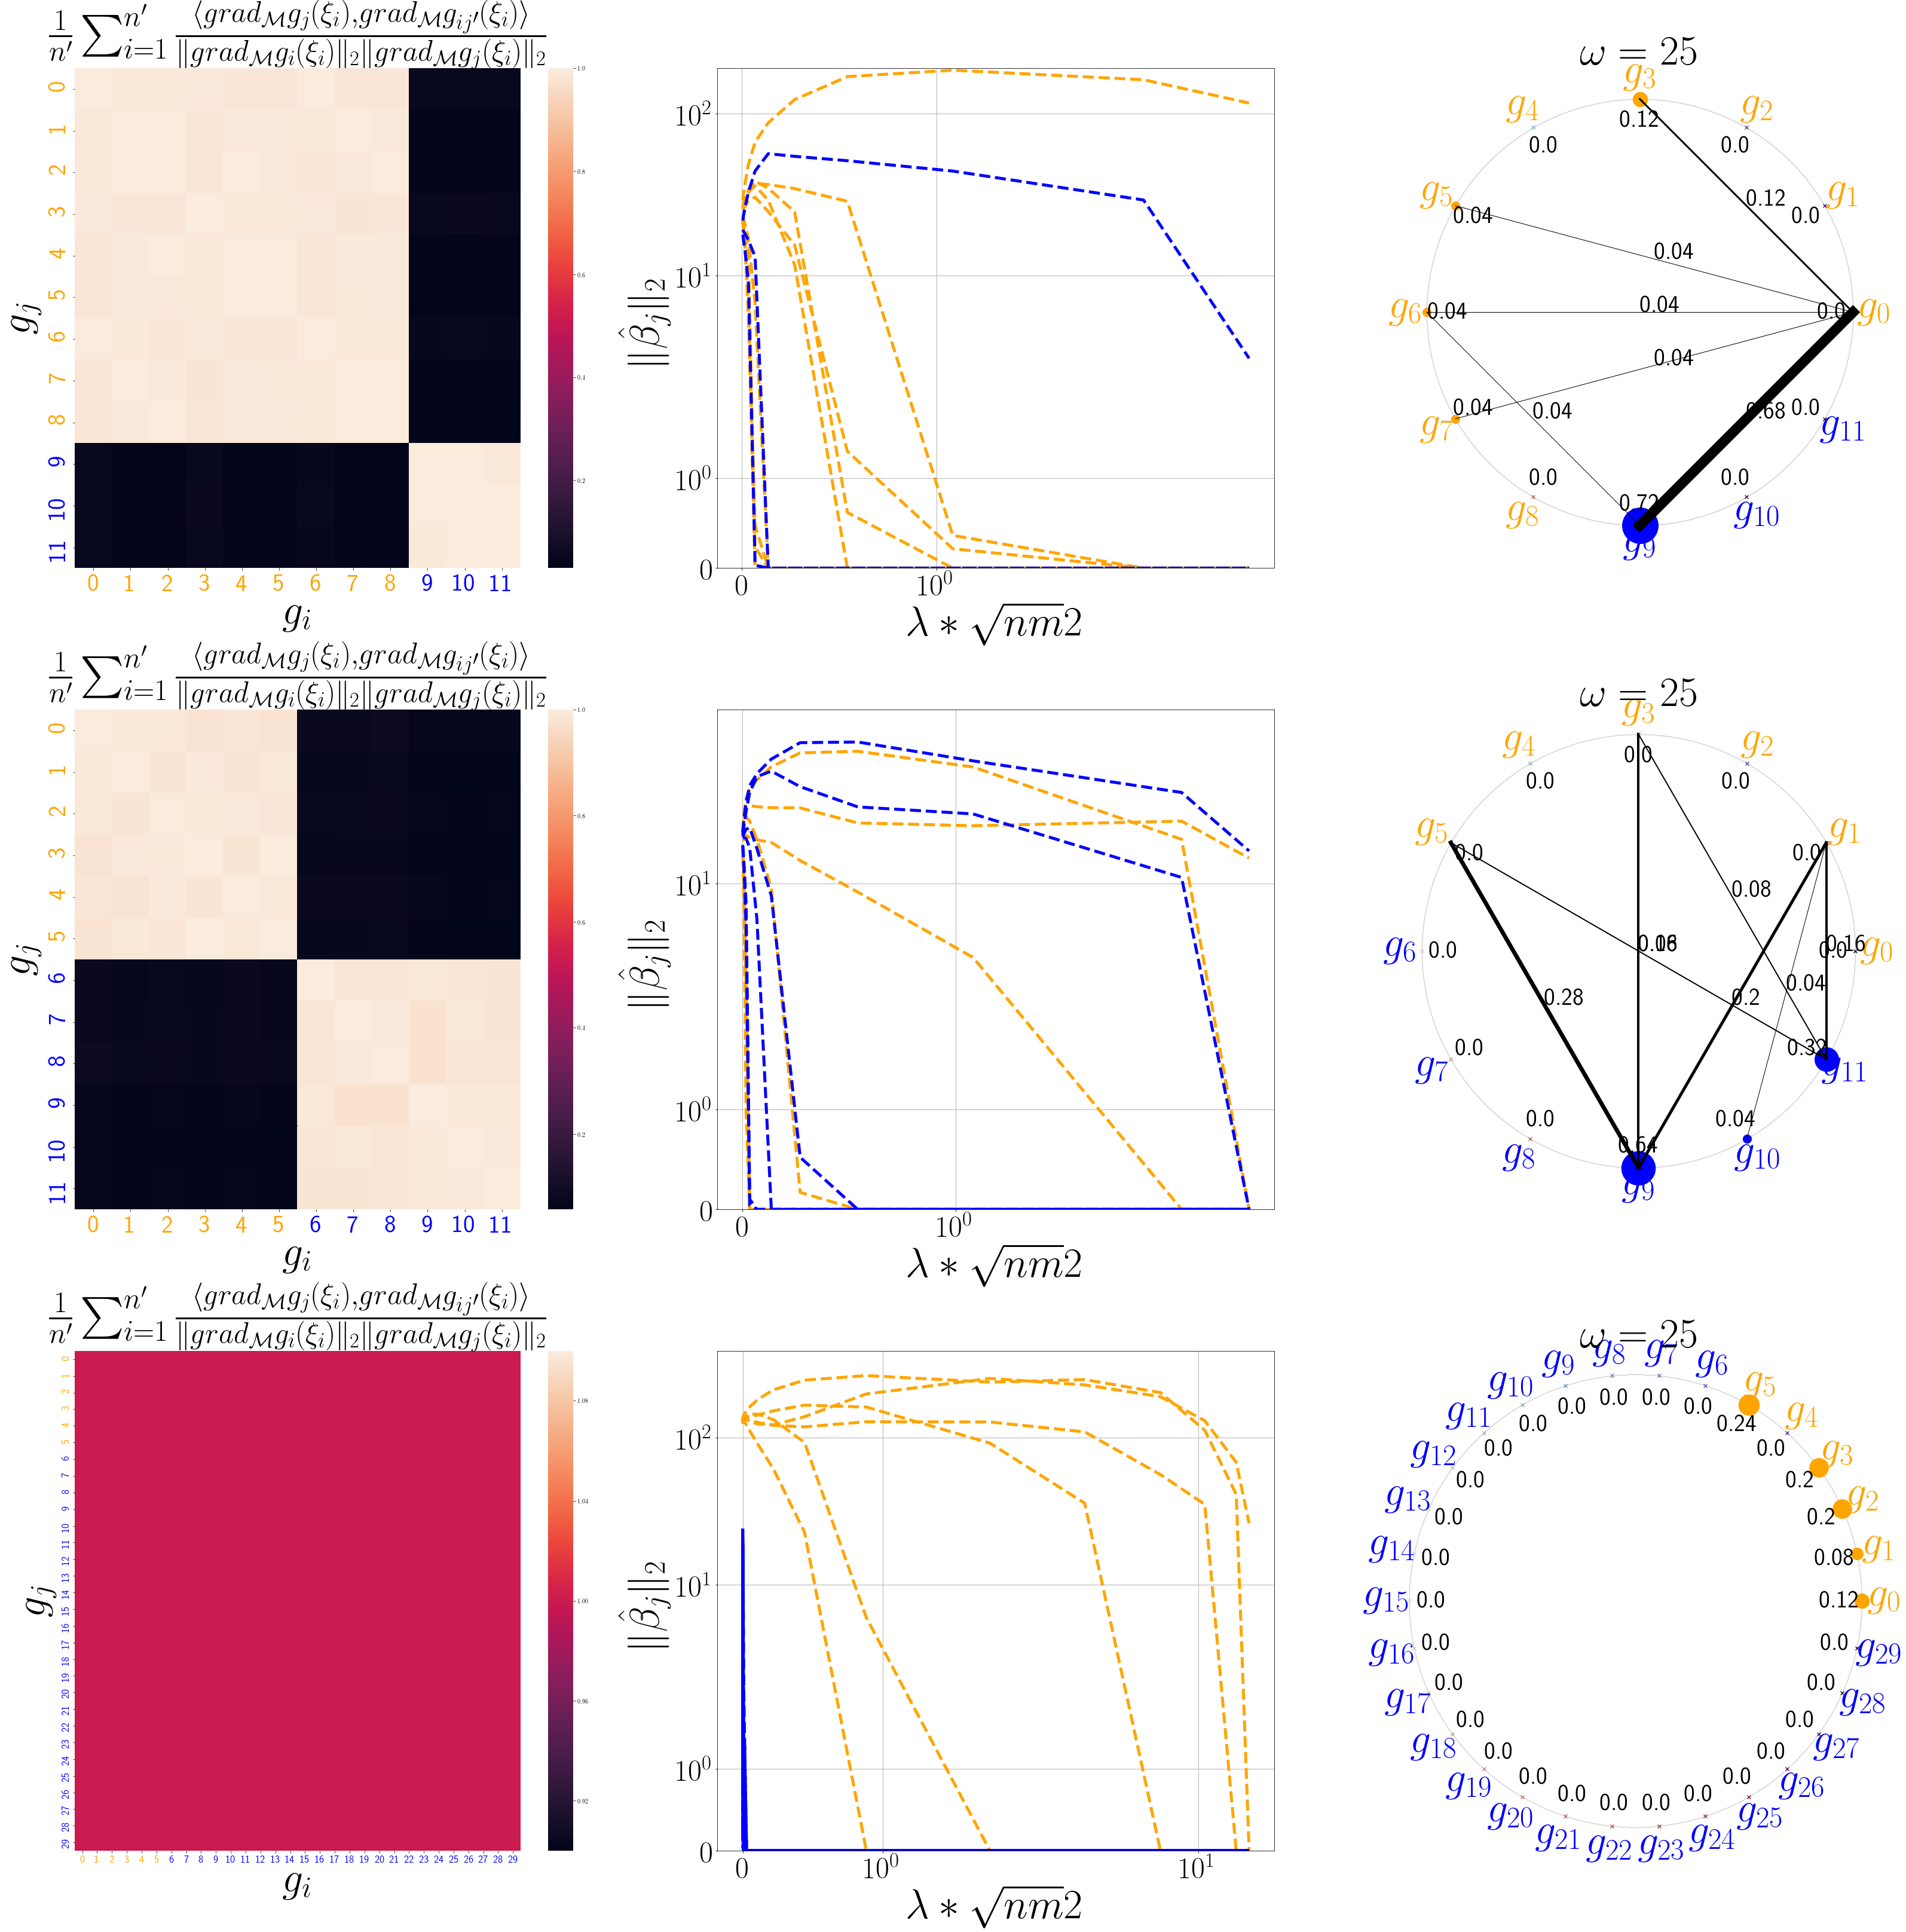

In [171]:
%matplotlib inline
#fig,axes == plt.subplot(3,3,figsize=(15,15))
fig, axes_all = plt.subplots(3,3,figsize=(45,45))

eth_cosine = get_cosines(replicates_ethanol[1].dg_M)
#sns.heatmap(eth_cosine, ax = axes_all[0,0],)
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(eth_cosine, axes_all[0,0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[0,1], replicates_ethanol[1].coeffs, replicates_ethanol[1].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_ethanol, 12, axes_all[0,2],colors)

mal_cosine = get_cosines(replicates_malonaldehyde[0].dg_M)
#sns.heatmap(mal_cosine, ax = axes_all[1,0])
colors = np.hstack([np.repeat('orange',6), np.repeat('blue',6)])
plot_cosines(mal_cosine, axes_all[1,0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[1,1], replicates_malonaldehyde[0].coeffs, replicates_malonaldehyde[0].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_malonaldehyde, 12, axes_all[1,2],colors)

tol_cosine = get_cosines(replicates_toluene[2].dg_M)
#sns.heatmap(tol_cosine, ax = axes_all[2,0])
colors = np.hstack([np.repeat('orange',6), np.repeat('blue',24)])
plot_cosines(tol_cosine, axes_all[2,0], colors)

#fig, axes_all = plt.subplots(figsize=(15,15))
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[2,1], replicates_toluene[2].coeffs, replicates_toluene[2].lambdas_plot * np.sqrt(2 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_toluene, 30, axes_all[2,2],colors)

fig.tight_layout()
plt.savefig('bigwan')

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004
1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004
1.0 0.0
0.9781476007338057 0.20791169081775931
0.9135454576426009 0.40673664307580015
0.8090169943749475 0.5877852522924731
0.6691306063588583 0.7431448254773941
0.5000000000000001 0.86602540378

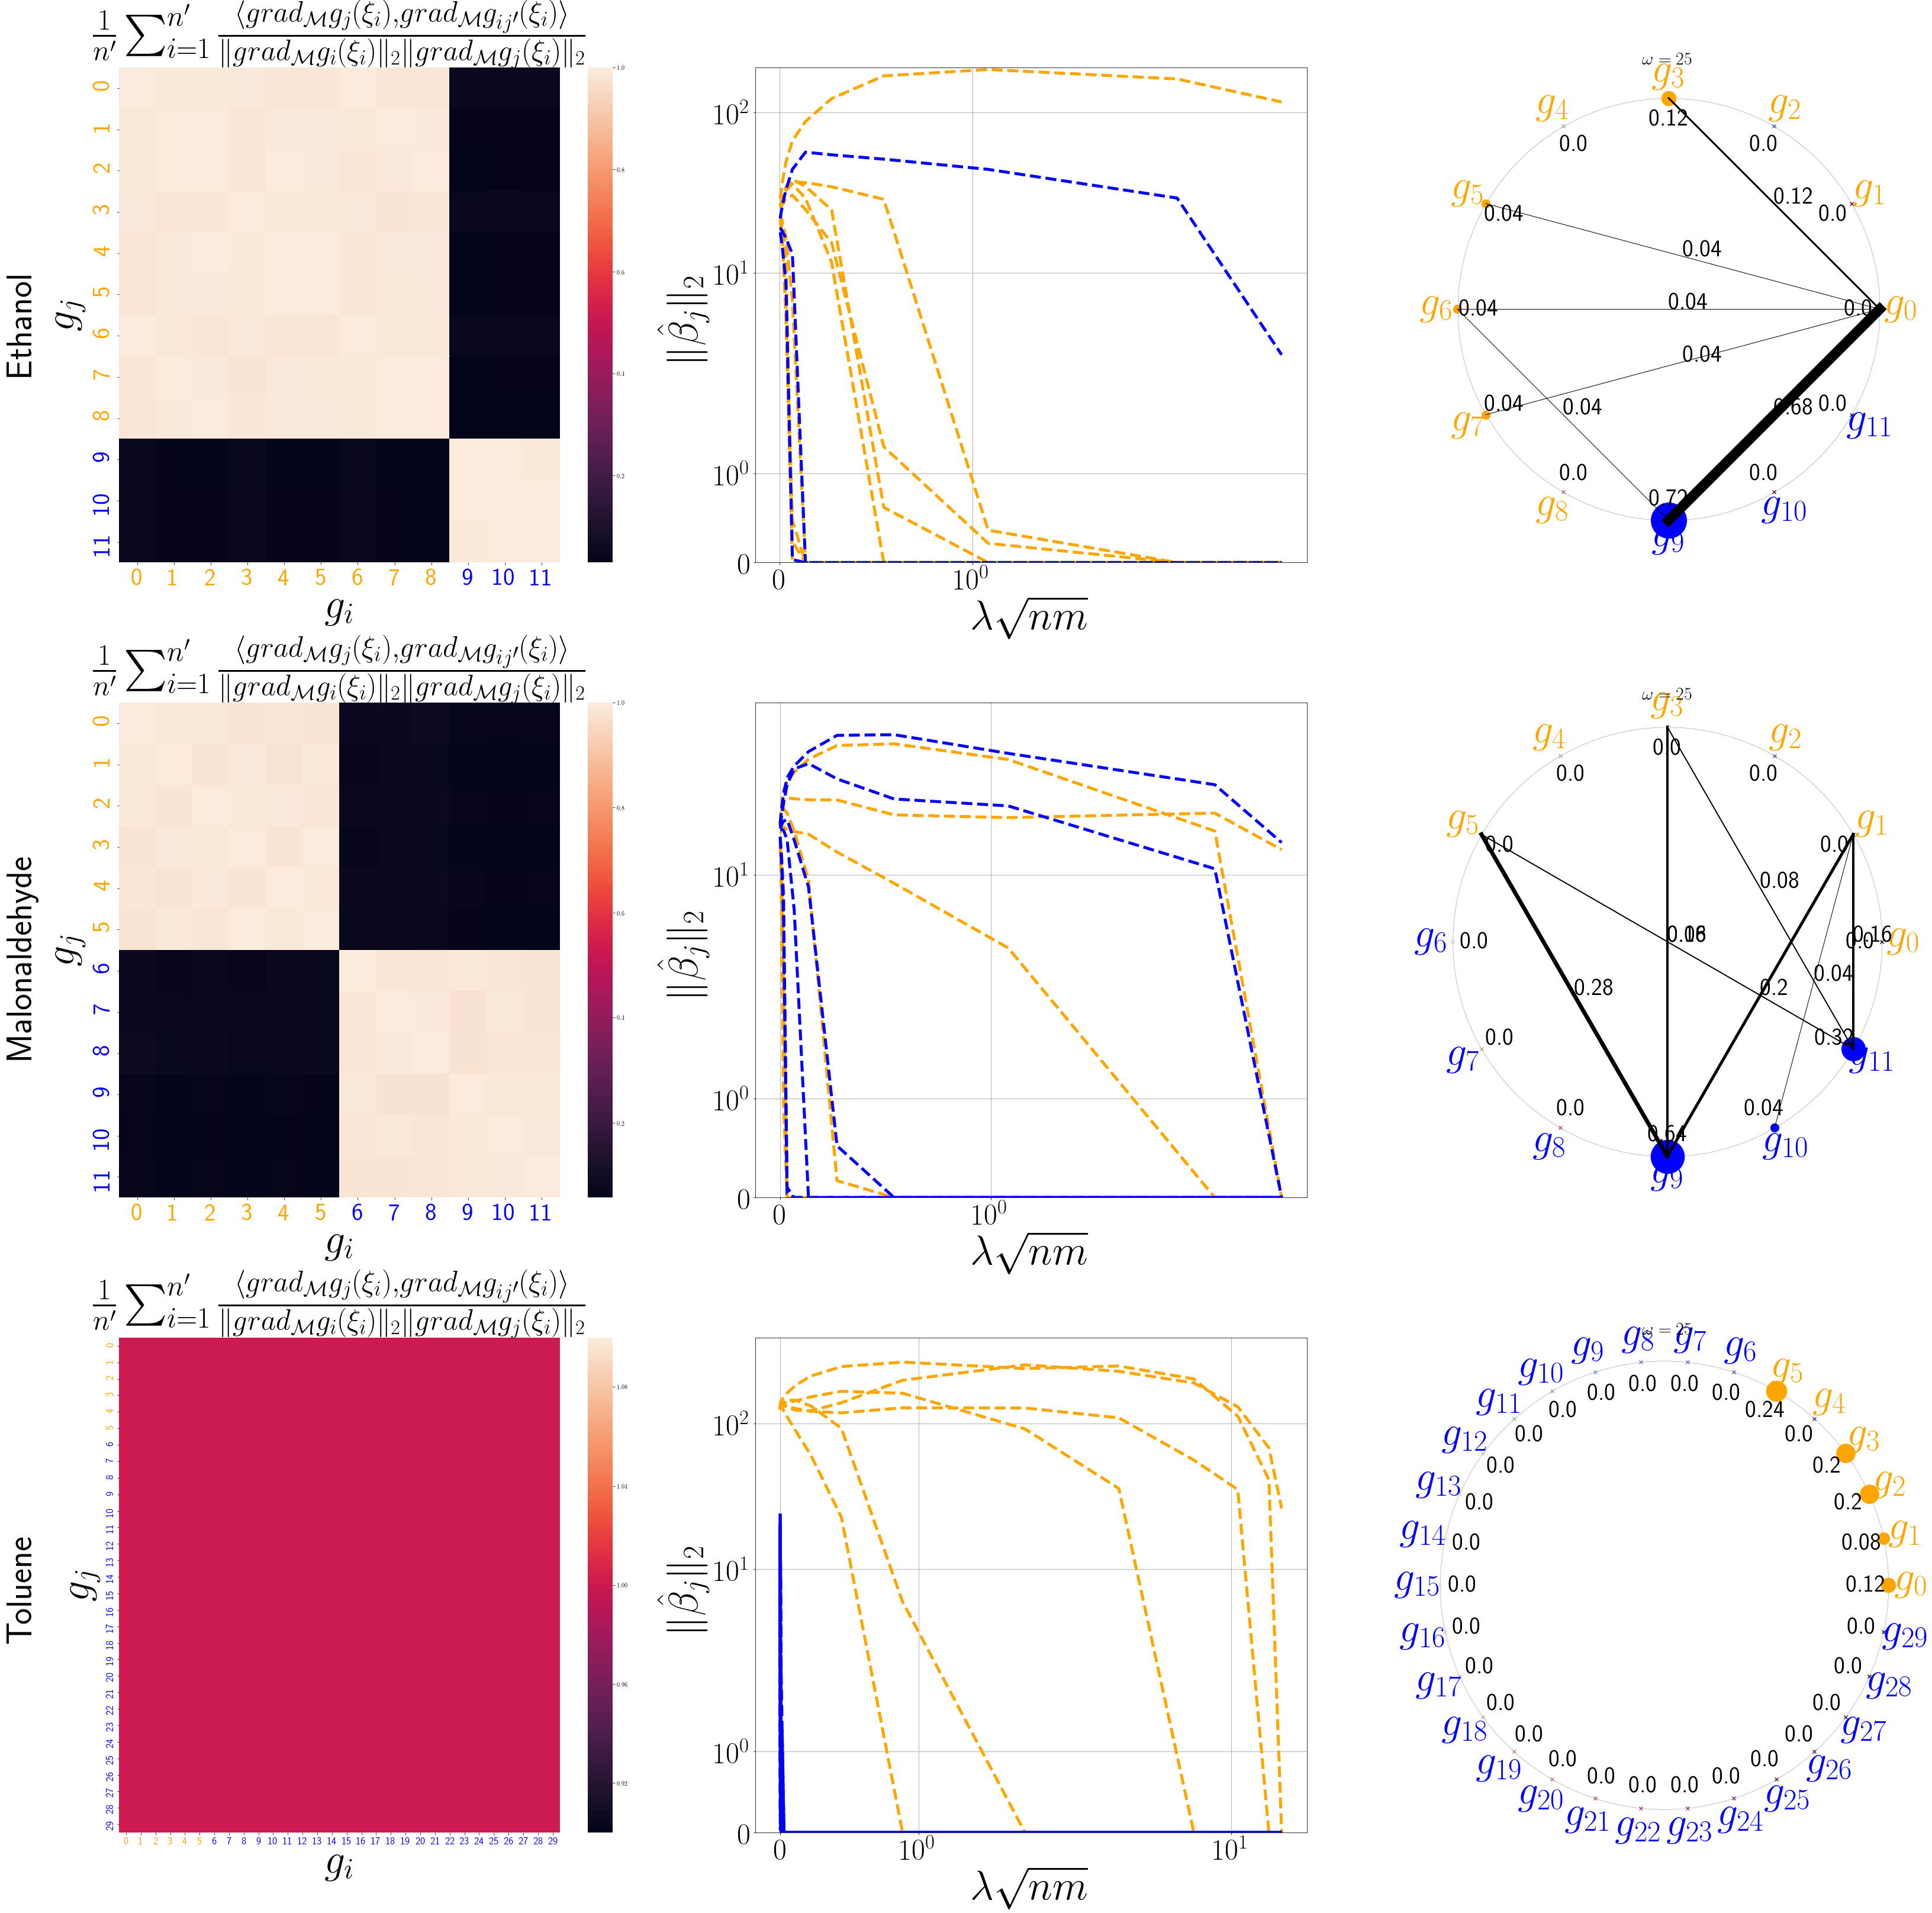

In [216]:
%matplotlib inline
#fig,axes == plt.subplot(3,3,figsize=(15,15))
fig, axes_all = plt.subplots(3,3,figsize=(45,45))

eth_cosine = get_cosines(replicates_ethanol[1].dg_M)
#sns.heatmap(eth_cosine, ax = axes_all[0,0],)
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(eth_cosine, axes_all[0,0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[0,1], replicates_ethanol[1].coeffs, replicates_ethanol[1].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_ethanol, 12, axes_all[0,2],colors)

mal_cosine = get_cosines(replicates_malonaldehyde[0].dg_M)
#sns.heatmap(mal_cosine, ax = axes_all[1,0])
colors = np.hstack([np.repeat('orange',6), np.repeat('blue',6)])
plot_cosines(mal_cosine, axes_all[1,0], colors)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[1,1], replicates_malonaldehyde[0].coeffs, replicates_malonaldehyde[0].lambdas_plot * np.sqrt(3 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_malonaldehyde, 12, axes_all[1,2],colors)

tol_cosine = get_cosines(replicates_toluene[2].dg_M)
#sns.heatmap(tol_cosine, ax = axes_all[2,0])
colors = np.hstack([np.repeat('orange',6), np.repeat('blue',24)])
plot_cosines(tol_cosine, axes_all[2,0], colors)

#fig, axes_all = plt.subplots(figsize=(15,15))
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all[2,1], replicates_toluene[2].coeffs, replicates_toluene[2].lambdas_plot * np.sqrt(2 * 100), fig,colors)#axes_all[0].imshow(asdf)
plot_watch_custom(toplot_toluene, 30, axes_all[2,2],colors)
fig.text(-0.01, 0.17, 'Toluene', ha='center', va='center', rotation='vertical', fontsize = 60)
fig.text(-0.01, 0.83, 'Ethanol', ha='center', va='center', rotation='vertical', fontsize = 60)
fig.text(-0.01, 0.5, 'Malonaldehyde', ha='center', va='center', rotation='vertical', fontsize = 60)

fig.tight_layout()
fig.savefig('bigwan3', bbox_inches = "tight")

In [ ]:
def get_cosines(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,
                                                                :])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    cos_summary = np.sum(coses ** 2, axis=0) / n
    return (cos_summary)

In [209]:
dg = replicates_toluene[2].dg_M

In [211]:
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,
                                                                :])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]


In [212]:
dg[i, j, :]

array([-0.00999068])

In [207]:
get_cosines(replicates_toluene[2].dg_M)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

In [191]:
from IPython.display import display, Math, Latex
import seaborn as sns

In [189]:
def plot_cosines(cosines, ax, colors):
    p = cosines.shape[0]
    sns.heatmap(cosines ,ax = ax)
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), colors):
        ytick.set_color(color)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 500 / p)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 500 / p)
    
    ax.set_ylabel(r"$g_j$", fontsize = 70)
    ax.set_xlabel(r"$g_i$", fontsize = 70)
    #ax.set_title(r"$\text{hi}$")
    ax.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{ij'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_i (\xi_i) \|_2 \| grad_{\mathcal M} g_j(\xi_i) \|_2} $",
                fontsize = 70)

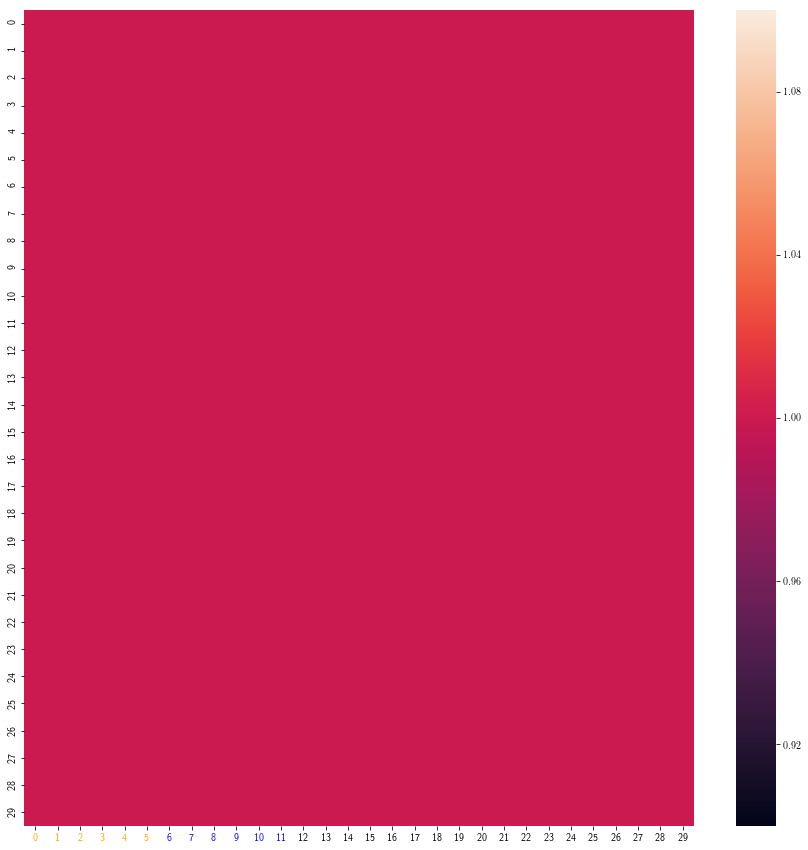

In [116]:


#fig,axes == plt.subplot(3,3,figsize=(15,15))
fig, axes_all = plt.subplots(figsize=(15,15))
sns.heatmap(tol_cosine ,ax = axes_all)
#.set_yticklabels(list(range(30)), colors = colors)


In [90]:
toplot_toluene.shape

(30,)

In [ ]:
ax.set_ylabel('')    
ax.set_xlabel('')


In [72]:
import math
from collections import OrderedDict

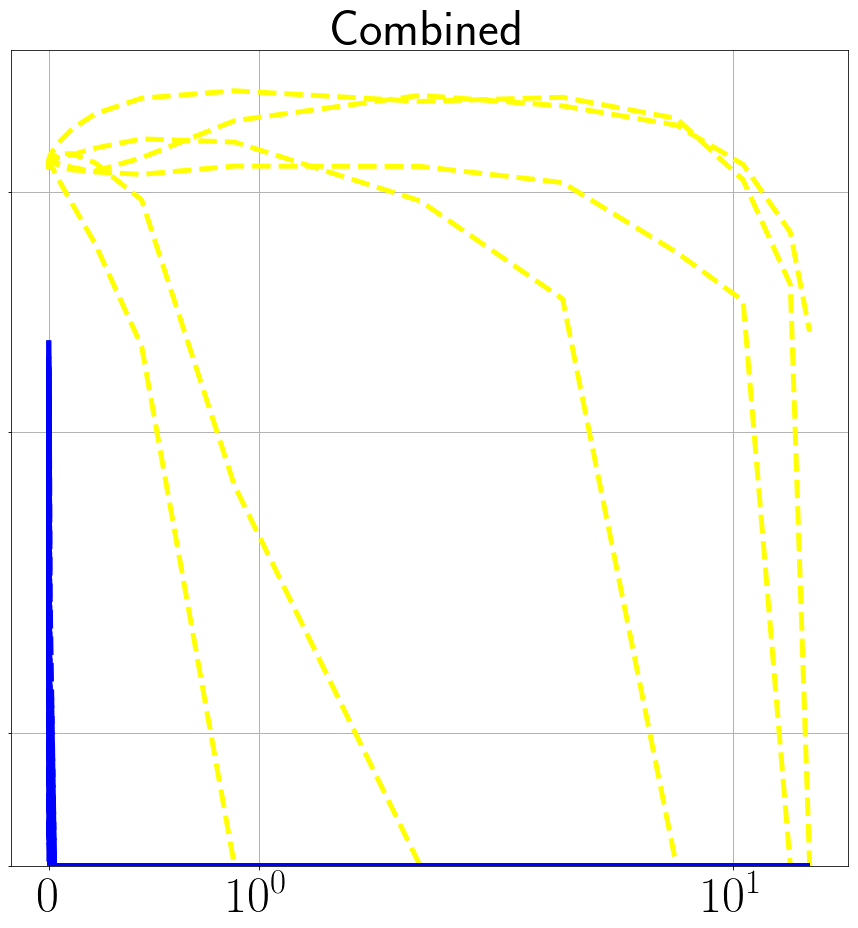

In [76]:
fig, axes_all = plt.subplots(figsize=(15,15))
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates_toluene[2].coeffs, replicates_toluene[2].lambdas_plot * np.sqrt(2 * 100), fig,colors)

In [51]:
replicates_toluene[2].dg_M

array([[[-0.038547  ],
        [ 0.04660775],
        [ 0.03800737],
        ...,
        [ 0.00109982],
        [-0.00164593],
        [-0.00361722]],

       [[ 0.03721229],
        [ 0.03414262],
        [-0.04253029],
        ...,
        [ 0.00589545],
        [ 0.00024892],
        [ 0.01104717]],

       [[ 0.04142791],
        [-0.03168913],
        [-0.03895353],
        ...,
        [ 0.0009522 ],
        [ 0.00058877],
        [ 0.00508796]],

       ...,

       [[ 0.04076466],
        [-0.0417382 ],
        [ 0.02911868],
        ...,
        [ 0.0023406 ],
        [-0.00209048],
        [ 0.00605616]],

       [[ 0.03771557],
        [ 0.03058507],
        [-0.03915161],
        ...,
        [ 0.00312685],
        [ 0.0004363 ],
        [-0.00956966]],

       [[-0.02939932],
        [-0.03574017],
        [ 0.04259356],
        ...,
        [-0.00077851],
        [ 0.00362572],
        [-0.00999068]]])

In [27]:
import seaborn as sns

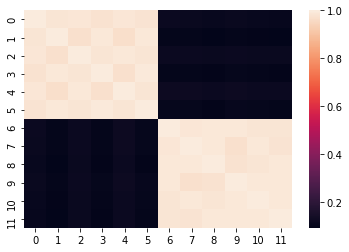

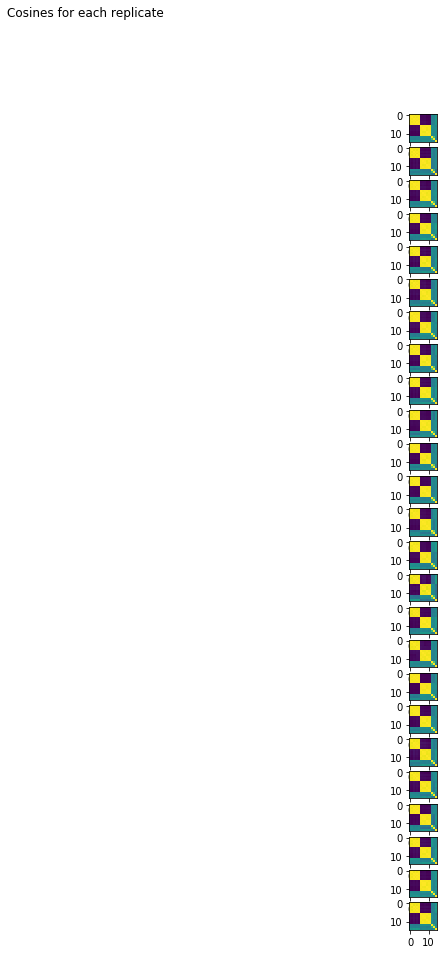

In [42]:
%matplotlib inline
fig, axes_all = plt.subplots(nreps,figsize=(15*nreps,15))
fig.suptitle('Cosines for each replicate')
for i in range(nreps):
    full = np.concatenate([replicates_malonaldehyde[i].dg_M, np.swapaxes(replicates_malonaldehyde[i].df_M,1,2)],1)
    asdf = get_cosines(full)
    #print(asdf)
    axes_all[i].imshow(asdf)

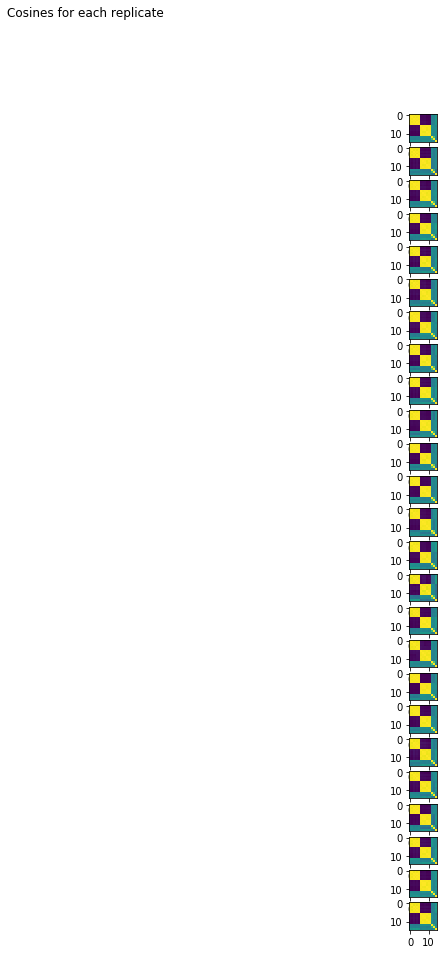

In [21]:
%matplotlib inline
fig, axes_all = plt.subplots(nreps,figsize=(15*nreps,15))
fig.suptitle('Cosines for each replicate')
for i in range(nreps):
    full = np.concatenate([replicates_malonaldehyde[i].dg_M, np.swapaxes(replicates_malonaldehyde[i].df_M,1,2)],1)
    asdf = get_cosines(full)
    #print(asdf)
    axes_all[i].imshow(asdf)

In [129]:
angles = np.linspace(0,2*np.pi, 10000)

In [130]:
ys  = np.sin(angles)
xs  = np.cos(angles)

In [204]:
i = 1000
nebs = np.asarray(np.linspace(900,1100,201), int)
data = np.asarray([xs,ys]).transpose()

In [270]:
tan = np.asarray([[-np.sin(angles[i]) , np.cos(angles[i])]])

In [248]:
angles[i]

0.6283813688548442

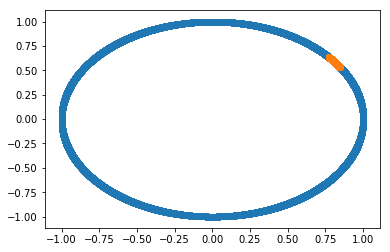

In [251]:
plt.scatter(xs, ys)
plt.scatter(xs[nebs], ys[nebs])
#plt.arrow(xs[i],ys[i],xs[i] + tan[0] ,ys[i] + tan[1])

In [282]:
tan @ tan.transpose() @ data

ValueError: shapes (1,1) and (10000,2) not aligned: 1 (dim 1) != 10000 (dim 0)

In [286]:
data @ tan.transpose() @ tan

array([[ 0.34555127, -0.47554767],
       [ 0.34525237, -0.47513634],
       [ 0.34495334, -0.47472481],
       ...,
       [ 0.34614864, -0.47636978],
       [ 0.34585002, -0.47595882],
       [ 0.34555127, -0.47554767]])

In [288]:
np.linalg.svd(tan.transpose() @ tan)

(array([[-0.58783609,  0.80898006],
        [ 0.80898006,  0.58783609]]),
 array([1.0000000e+00, 6.5262916e-17]),
 array([[-0.58783609,  0.80898006],
        [ 0.80898006,  0.58783609]]))

In [278]:
asdf = tan.transpose() @ tan

In [277]:
 tan @ tan.transpose()

array([[1.]])

In [276]:
tan.transpose() @ tan

array([[ 0.34555127, -0.47554767],
       [-0.47554767,  0.65444873]])

In [290]:
pm = tan.transpose() @ tan#np.outer(tan, tan)

In [297]:
pd = (data[nebs] - data[i]) @ pm

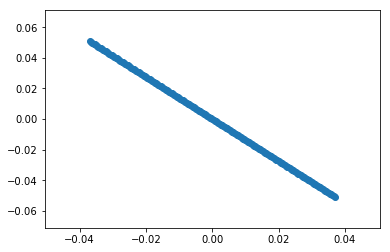

In [298]:
plt.scatter(pd[:,0], pd[:,1])

In [299]:
import scipy.stats

In [300]:
x = np.expand_dims(angles[nebs],1) - angles[i]
y = pd

(x.transpose() @ x)**(-1) @ x.transpose() @ y

array([[-0.58760169,  0.80865748]])

In [301]:
x = np.expand_dims(angles[nebs],1) - angles[i]
y = data[nebs] - data[i]

(x.transpose() @ x)**(-1) @ x.transpose() @ y

array([[-0.58760169,  0.80865748]])

In [304]:
x = 15*np.cos(angles)
y = np.sin(angles)

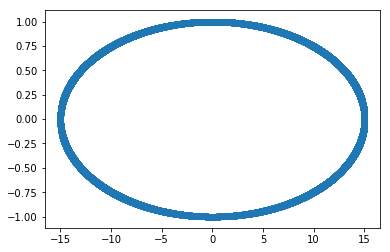

In [305]:
plt.scatter(x,y)

In [306]:
i = 5000
nebs = np.asarray(np.linspace(4900,5100,201), int)
data = np.asarray([xs,ys]).transpose()

In [307]:
tan = np.asarray([[-15*np.sin(angles[i]) , np.cos(angles[i])]])

In [308]:
pm = tan.transpose() @ tan#np.outer(tan, tan)

In [309]:
pd = (data[nebs] - data[i]) @ pm

In [310]:
x = np.expand_dims(angles[nebs],1) - angles[i]
y = pd

(x.transpose() @ x)**(-1) @ x.transpose() @ y

array([[ 0.00471099, -0.99960259]])

In [311]:
x = np.expand_dims(angles[nebs],1) - angles[i]
y = data[nebs] - data[i]

(x.transpose() @ x)**(-1) @ x.transpose() @ y

array([[ 3.14065398e-04, -9.99601209e-01]])

In [166]:
angles[nebs].shape

(201,)

In [157]:
angles

array([0.00000000e+00, 6.28381369e-04, 1.25676274e-03, ...,
       6.28192854e+00, 6.28255693e+00, 6.28318531e+00])

In [ ]:
np.dot(data, )

In [137]:
nebs

array([ 900,  901,  902,  903,  904,  905,  906,  907,  908,  909,  910,
        911,  912,  913,  914,  915,  916,  917,  918,  919,  920,  921,
        922,  923,  924,  925,  926,  927,  928,  929,  930,  931,  932,
        933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
        944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,
        966,  967,  968,  969,  970,  971,  972,  973,  974,  975,  976,
        977,  978,  979,  980,  981,  982,  983,  984,  985,  986,  987,
        988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
        999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
       1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 10

In [95]:
to_plot = toplot_toluene
p = 30

1.0 0.0
0.9781476007338057 0.20791169081775931
0.9135454576426009 0.40673664307580015
0.8090169943749475 0.5877852522924731
0.6691306063588583 0.7431448254773941
0.5000000000000001 0.8660254037844386
0.30901699437494745 0.9510565162951535
0.10452846326765367 0.9945218953682733
-0.10452846326765333 0.9945218953682734
-0.30901699437494734 0.9510565162951536
-0.4999999999999998 0.8660254037844388
-0.6691306063588579 0.7431448254773945
-0.8090169943749473 0.5877852522924732
-0.9135454576426008 0.40673664307580043
-0.9781476007338056 0.20791169081775973
-1.0 1.2246467991473532e-16
-0.9781476007338057 -0.20791169081775907
-0.9135454576426011 -0.4067366430757998
-0.8090169943749475 -0.587785252292473
-0.6691306063588585 -0.743144825477394
-0.5000000000000004 -0.8660254037844384
-0.30901699437494756 -0.9510565162951535
-0.10452846326765423 -0.9945218953682733
0.104528463267653 -0.9945218953682734
0.30901699437494723 -0.9510565162951536
0.4999999999999993 -0.866025403784439
0.6691306063588578 -

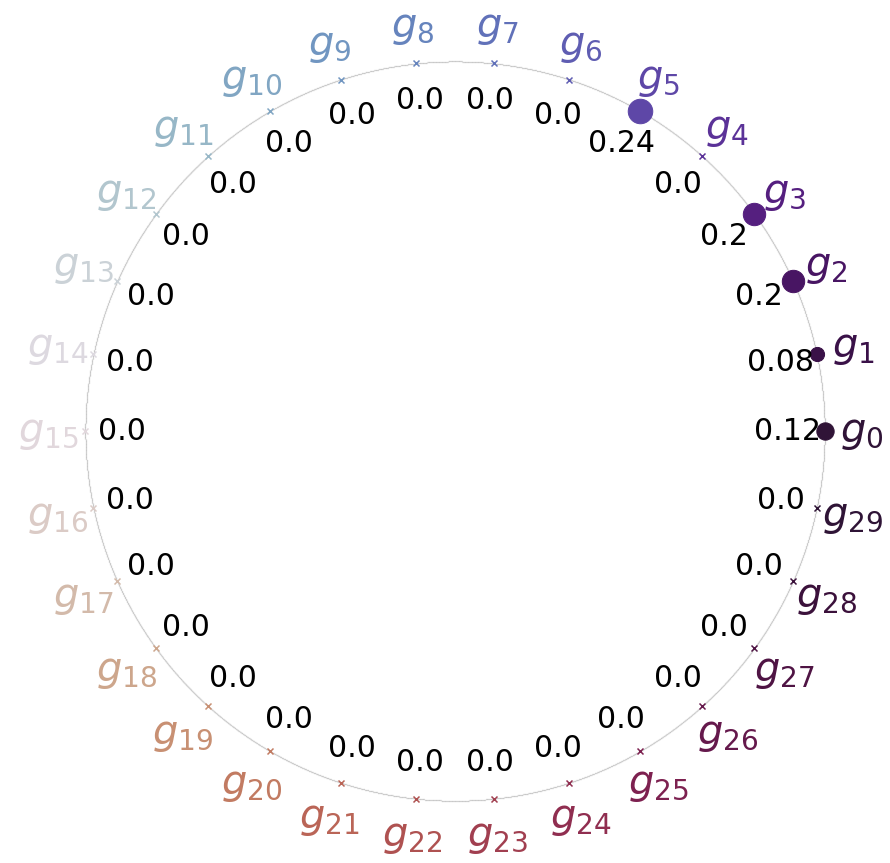

In [100]:
    %matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    axes.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'x')
        axes.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = r"$g_{{{}}}$".format(j),color=cmap.colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')



        axes.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=cmap.colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                plt.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    axes.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')

                #axes.axline((x1, y1), (x2, y2))
    axes.set_aspect(1)
    axes.set_axis_off()

In [92]:
totes

21.0

In [93]:
to_plot.shape

(30,)